# Generali building claim
---------------------------------

<font size=3.5 ><text><strong>This project builds a model that predicts claims during the insured period of a building.
</strong></text></font>

<br><br><font size=3.5><u><b>Context</b></u></font>
<br>
Building insurance is a non life insurance policy that protects the structure of your home – <br>
the walls, roof, floors and common areas– against damage that could be caused by a flood or storm,<br> 
by a fire or vandalism.<br><br><br>

Generali decided to open a data challenge with the "Ecole Normale Supérieur" to permit students and professional to work on a real case study.

I have decided to apply machine learning lessons on this real case and stude unbalanced data.<br> 

To realise this project i organized myself with the Cross Industry Strand Process for Data Mining as described below.


<br>
<img src="./img/CISP-DM.jpg" alt="Analyze Process for Generali data challenge">
<br>
It is really difficult to display the project path on a notebook, because data researches, data preparation and modelling are the place of lots of try and fails.
In this notebook we have a status of data exploration and collection plus a first random forest manually tuned.<br>

<font size=3.5><u><b>The goal of the challenge</b></u></font> is to predict if a building will have an insurance claim during a certain period. You will have to predict a probability of having at least one claim over the insured period of a building. The model will be based on the building characteristics. The target variable is a:

    - 1 if the building has at least a claim over the insured period.

    - 0 if the building doesn’t have a claim over the insured period.
<br>
<br>

The project starts with a list of anonymised data provided by Generali.<br><br>
<font size=3.5><u><b>Generali Data Description</b></u></font>
<br><font color='blue'>Identifiant:</font> variable to identify client in our database. 
<br><font color='blue'>ft_2_categ:</font> year of observation for the insured policy.
<br><font color='blue'>EXPO:</font> time insured in Generali on the year. (Ex: Full year insurance EXPO = 1; 6 months EXPO = 0.5 ) Numerical variable.
<br><font color='blue'>superficief:</font> size in m2 of the insured building. Numerical variable.
<br><font color='blue'>Insee:</font> French geographical code to locate the insured building. Very useful to add external data. Geographical/categorical variable.
<br><b><font color='green'>target:</font></b> target variable. (0: no claim, 1: at least one claim over insured period).
<br><font color='blue'>other ft_{i}_categ :</font> anonymized caracteristics of the building. Categorical variables.
  
<font size=3.5><strong><u>Data preparation</u></strong></font>
<br>
<img src="./img/data_prep.jpg" alt="Data collected for the Generali data challenge">
<br>


<br>
<br>
<font size=3.5><strong><u>Notebook structure</u></strong></font>
<br>
<ul>
<li>  I  – <a href="#chapI">Explore data</a></li>
<li> II  – <a href="#chapII">Look for missing data shape</a></li>
<li>III  – <a href="#chapIII">Reorganize data distribution</a></li>
<li> IV  – <a href="#chapIV">Clean up rows not having Insee values</a></li>
<li>  V  – <a href="#chapV">Transform category to dummies column</a></li>
<li> VI   – <a href="#chapVI">Impute [ft_22_categ / superficief] NaN</a></li>
<li>VII  – <a href="#chapVII">Look for hidden signal</a></li>
<li>VIII – <a href="#chapVIII">Add external data</a></li>
<li> IX  – <a href="#chapIX">Clustering </a></li>
<li>  X  – <a href="#chapX">Looking for density with DBSCAN</a></li>
<li> XI  – <a href="#chapXI">Data correlation</a></li>
</ul>
<br>

## Explore DATA<p id="#chapI"></p>

--------------------------

--------------------------

<font size=3.5><strong>Load data and have a first look</strong></font>

--------------------

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

pd.options.display.float_format = '{:,.2f}'.format


%matplotlib inline

In [54]:
#Read train and test datasets
train = pd.read_csv("./X_train.csv")
test = pd.read_csv("./X_test.csv")
y_train = pd.read_csv("./y_train_saegPGl.csv")

#Keep the train row number, it will permit to extract train futher
train_shape0 = train.shape[0]

#Set the maximum columns value to display each columns
pd.options.display.max_columns = 1000
pd.options.display.float_format = '{:,.0f}'.format

#Have a look at the data structure
del y_train["Unnamed: 0"]
del train["Unnamed: 0"]
del test["Unnamed: 0"]
print(train.shape)
print(test.shape)
train.head()

(10229, 25)
(3412, 25)


,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,ft_12_categ,ft_13_categ,ft_14_categ,ft_15_categ,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee
0,18702,2014,1,0,V,N,1,O,1,O,N,N,N,N,AUTRE,IDENTIQUE,V,base,2,"1,351",4,"2,012",0.0,2,65440
1,3877,2014,1,0,V,V,V,V,V,V,V,V,V,V,V,V,N,base,2,"1,972",2,"1,980",0.0,.,14341
2,4942,2013,1,1,V,V,V,V,V,V,V,V,V,V,V,V,N,base,2,"1,630",4,nan,0.0,.,75109
3,13428,2013,"0,246575342",0,N,V,V,V,V,V,V,V,V,V,V,V,N,base,2,532,3,nan,0.0,.,92004
4,17137,2015,1,0,V,N,2,O,1,O,N,N,O,N,AUTRE,IDENTIQUE,V,base,2,"1,050",2,"1,972",0.0,4,59340


In [55]:
#Load target data
y_train.target.value_counts()

0    7907
1    2322
Name: target, dtype: int64

<b>--> The data target is unbalanced</b>

In [56]:
# Is there some building insured on several years ? (and suppose that Identifiant refers to a building)
train['Identifiant'].value_counts()[:5]

2047     1
17834    1
13748    1
19891    1
1458     1
Name: Identifiant, dtype: int64

In [57]:
del train['Identifiant']
del test['Identifiant']

# Add target to train dataset
train_target = pd.concat((train, y_train), axis = 1)
train_target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10229 entries, 0 to 10228
Data columns (total 26 columns):
ft_2_categ     10229 non-null int64
EXPO           10229 non-null object
ft_4_categ     10229 non-null int64
ft_5_categ     10229 non-null object
ft_6_categ     10229 non-null object
ft_7_categ     10229 non-null object
ft_8_categ     10229 non-null object
ft_9_categ     10229 non-null object
ft_10_categ    10229 non-null object
ft_11_categ    10229 non-null object
ft_12_categ    10229 non-null object
ft_13_categ    10229 non-null object
ft_14_categ    10229 non-null object
ft_15_categ    10229 non-null object
ft_16_categ    10229 non-null object
ft_17_categ    10229 non-null object
ft_18_categ    10229 non-null object
ft_19_categ    10229 non-null int64
superficief    10110 non-null float64
ft_21_categ    10229 non-null int64
ft_22_categ    8993 non-null float64
ft_23_categ    10229 non-null object
ft_24_categ    10229 non-null object
Insee          10114 non-null object
Identi

Exposition time is an object that we convert to float.


In [61]:
train["EXPO"] = train["EXPO"].str.replace(",",".").astype(float)
test["EXPO"] = test["EXPO"].str.replace(",",".").astype(float)


In [62]:
combine = train.append(test)
combine.reset_index(inplace=True)
combine.drop('index', inplace=True, axis=1)

###  Locate claims recorded


In [63]:
import geopandas as gpd

# Read "France" shapefile
# Source : https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/
map_df = gpd.read_file("./data/geo/departements-20140306-5m.shp")

# check data loaded
map_df_Metropole = map_df.iloc[0:96,:]
map_df_Guadeloupe = map_df.iloc[98:98,:]
map_df_Martinique = map_df.iloc[99:99,:]
map_df_Guyane = map_df.iloc[100:100,:]
map_df_Reunion = map_df.iloc[101:101,:]
map_df_Mayotte = map_df.iloc[102:102,:]

map_df.tail(10)

,code_insee,nom,nuts3,wikipedia,geometry
91,91,Essonne,FR104,fr:Essonne (département),"POLYGON ((2.392328496135124 48.33592916158408,..."
92,92,Hauts-de-Seine,FR105,fr:Hauts-de-Seine,"POLYGON ((2.319926260528716 48.7707501725293, ..."
93,93,Seine-Saint-Denis,FR106,fr:Seine-Saint-Denis,"POLYGON ((2.418994715849627 48.84938657374529,..."
94,94,Val-de-Marne,FR107,fr:Val-de-Marne,"POLYGON ((2.414497659705796 48.71780178979385,..."
95,95,Val-d'Oise,FR108,fr:Val-d'Oise,"POLYGON ((1.796736299947983 49.07195815991548,..."
96,971,Guadeloupe,FR910,fr:Guadeloupe,(POLYGON ((-61.61402941320713 15.8395477602560...
97,972,Martinique,FR920,fr:Martinique,(POLYGON ((-60.86880349267127 14.3909057613284...
98,973,Guyane,FR930,fr:Guyane,(POLYGON ((-52.58463013337558 5.28309137731124...
99,974,La Réunion,FR940,fr:La Réunion,(POLYGON ((55.77885611721816 -21.3629143474847...
100,976,Mayotte,None,fr:Mayotte,(POLYGON ((45.13666936665152 -13.0039774513961...


In [64]:
# Manage train and target data to sum rows grouped by  "French Department" and "target types"

# Filter Insee Null values and build Departement feature
train_target_toMap = train_target[(train_target["Insee"].isnull()==False)].copy()
train_target_toMap["Departement"] = train_target_toMap.Insee.str[0:2]

# Aggregate data by departement & target type
train_target_toMap = pd.DataFrame({'Count' : train_target_toMap.groupby(["Departement","target"])["target"].count()} ).reset_index()
train_target_toMap.head()
    


,Departement,target,Count
0,01,0,15
1,01,1,3
2,02,0,5
3,02,1,1
4,03,0,11


In [65]:
# Merge shape file and claims data 
merged = map_df_Metropole.set_index("code_insee").join(train_target_toMap.set_index("Departement"))
merged.head()

,nom,nuts3,wikipedia,geometry,target,Count
01,Ain,FR711,fr:Ain (département),"POLYGON ((5.255594917214185 45.78458957592071,...",0,15
01,Ain,FR711,fr:Ain (département),"POLYGON ((5.255594917214185 45.78458957592071,...",1,3
02,Aisne,FR221,fr:Aisne (département),"POLYGON ((3.481745983906527 48.86640497465348,...",0,5
02,Aisne,FR221,fr:Aisne (département),"POLYGON ((3.481745983906527 48.86640497465348,...",1,1
03,Allier,FR721,fr:Allier (département),"POLYGON ((2.386134612251119 46.33196381367623,...",0,11


In [66]:
merged.sort_values(by=['Count'], ascending = False)[0:10]

,nom,nuts3,wikipedia,geometry,target,Count
13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,(POLYGON ((5.389133796111915 43.18474670671392...,0,"1,009"
06,Alpes-Maritimes,FR823,fr:Alpes-Maritimes,(POLYGON ((7.072205814002613 43.51569410585097...,0,621
83,Var,FR825,fr:Var (département),(POLYGON ((6.393822276116695 42.98768988773867...,0,377
75,Paris,FR101,fr:Paris,"POLYGON ((2.351984617736146 48.90149278649145,...",0,372
06,Alpes-Maritimes,FR823,fr:Alpes-Maritimes,(POLYGON ((7.072205814002613 43.51569410585097...,1,309
92,Hauts-de-Seine,FR105,fr:Hauts-de-Seine,"POLYGON ((2.319926260528716 48.7707501725293, ...",0,295
13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,(POLYGON ((5.389133796111915 43.18474670671392...,1,266
74,Haute-Savoie,FR716,fr:Haute-Savoie,"POLYGON ((6.808742607415864 45.81356781783614,...",0,264
38,Isère,FR714,fr:Isère (département),"POLYGON ((5.447811031818375 45.07178358134775,...",0,251
64,Pyrénées-Atlantiques,FR615,fr:Pyrénées-Atlantiques,(POLYGON ((-1.575481604795459 43.4826662976400...,0,212


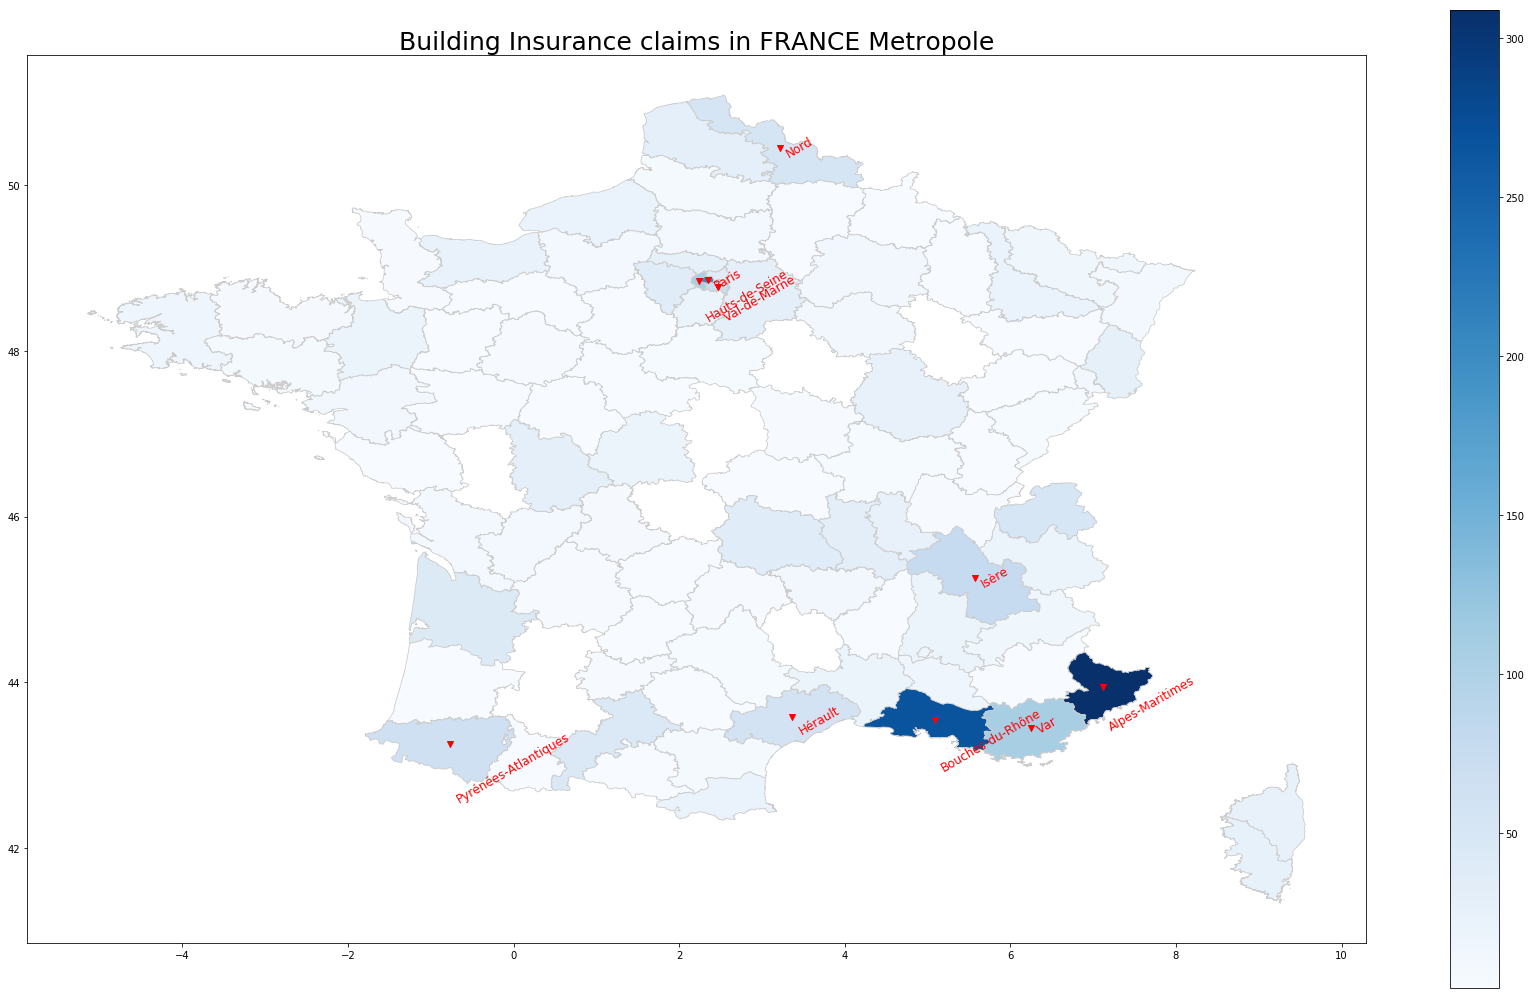

In [67]:
# Map the claims
# Params :
#     - GeoPandas DataFrame 
#     - Feature to analyze
#     - Map title
def build_map(df, l_feature, l_title, l_labels):
    # Set the range for the choropleth
    #vmin, vmax = min(df.Count),max(df.Count)
    vmin, vmax = min(df[l_feature]),max(df[l_feature])


    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 18))
    ax.set_title(l_title, fontdict={"fontsize": "25", "fontweight" : "3"})

    # Create the claims map 
    ax = df.plot(column=l_feature, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # empty array for the data range
    sm._A = []

    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    
    ###################
    # Manage map labels
    # Filter the top 10 given the feature param to display their label on the map
    df_labels = df.sort_values(by=[l_feature], ascending = False)[0:10]
    
    # Redefine the geometry with centroid
    df_labels['centroid_column'] = df_labels.centroid
    df_labels = df_labels.set_geometry('centroid_column')
    df_labels.plot(ax = ax, marker = "v", c = "red", )
    for x, y, label in zip(df_labels.geometry.x, df_labels.geometry.y, df_labels[l_labels]):
        ax.annotate(label, xy=(x, y), xytext=(4, 4), size=12, rotation=30, textcoords="offset points", color = "red")
    
    
    # Save the map on disk
    fig.savefig( "%s_%s%s" % ("map",l_feature,".png") , dpi=300)
    
    plt.show()
    
    
    
# Display a claims number map per department 
build_map(merged[merged.target==1], "Count", "Building Insurance claims in FRANCE Metropole", "nom")



We see clearly that the claims received by Generali is not homogene on the Metropole at all !<br>
There are some hot spots where claim risk seems to be higher than in any other department.<br>
Alpes-Maritimes is the more claim active department.<br>
To ensure that this density is linked to the area and not to a Generali business activity concentrated on this department we will evaluate a claim by client ratio in the next graph.

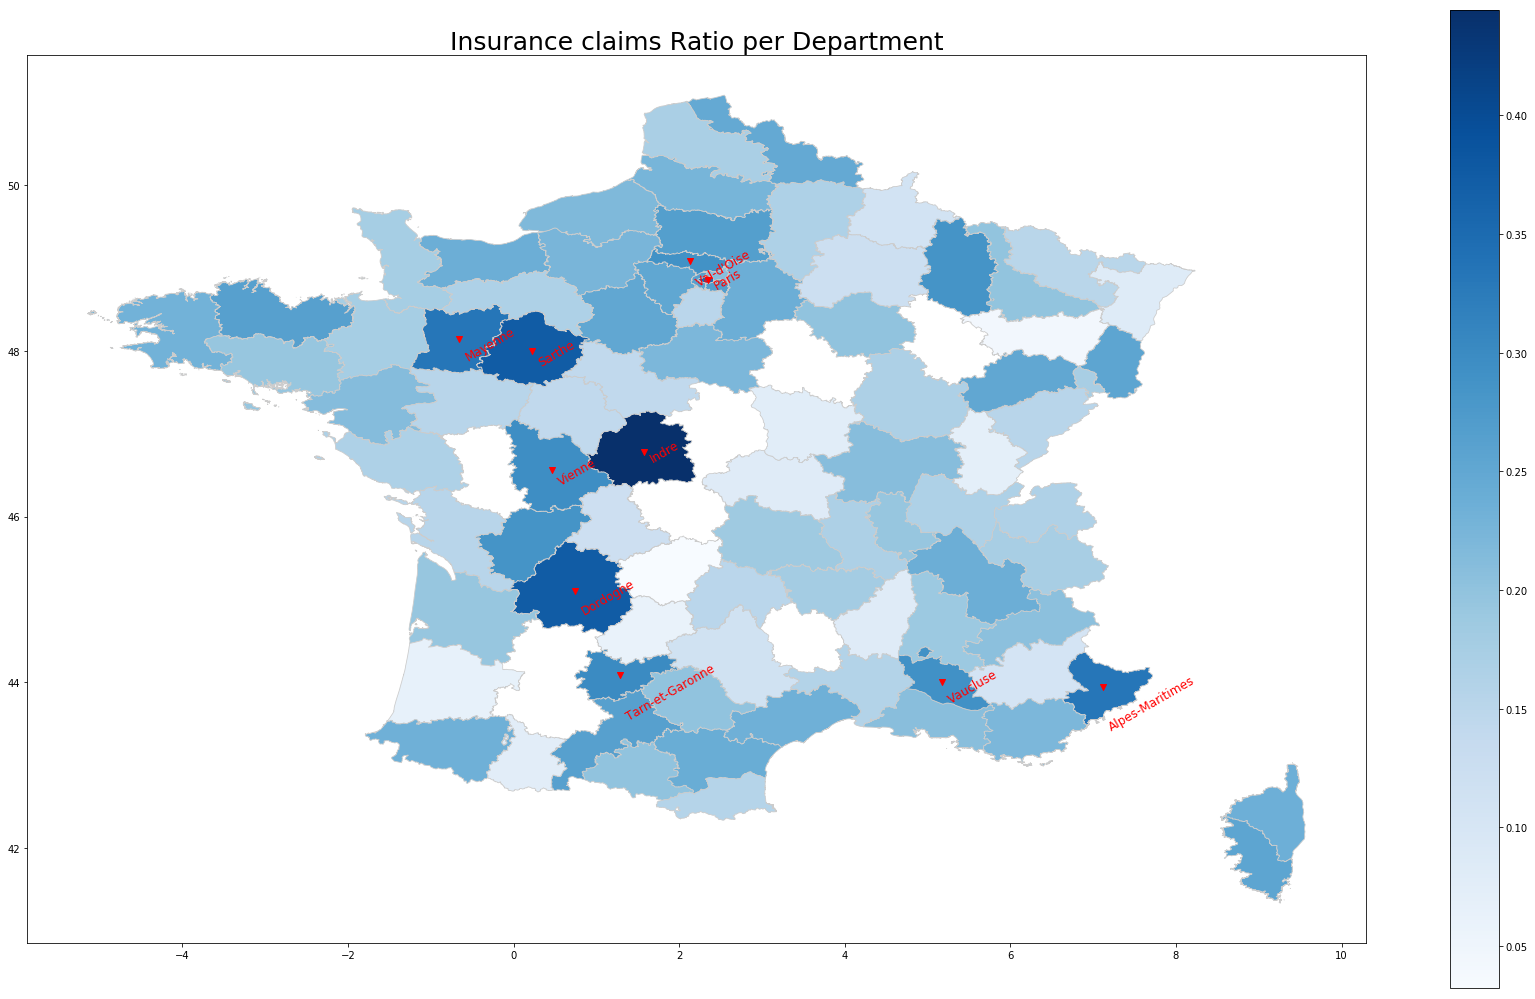

In [68]:
# Aggregate data by departement & calculate the claims ratio
train_department_toMap = pd.DataFrame({'Count_per_Dep' : train_target_toMap.groupby(["Departement"])["Count"].sum()} ).reset_index()
ratio_merged = merged.join(train_department_toMap.set_index("Departement"))
ratio_merged["Claims_Ratio"] = ratio_merged["Count"]/ratio_merged["Count_per_Dep"]
ratio_merged["Claims_Ratio"].values

# Display a claims Ratio per department 
build_map(ratio_merged[ratio_merged.target == 1], "Claims_Ratio", "Insurance claims Ratio per Department", "nom")


We can extract here a different view with the claims ratio, some departments need obviously to be under our attention.<br>
More specifically we identify here "Indre" as a top claim department, it would be very interesting to deal with a business manager about this department. After some internet research i did not identified any specifc reason for this behavior.<br>
Regarding areas, we were first focused on the south, now the middle east seems to hold more risk.<br> 
In the mean time "Alpes-Maritimes" and "Paris" have both a high ratio of claims given a set of insured clients and a high number of claims, so it is a hot spot for the company activity to manage with high attention. <br>


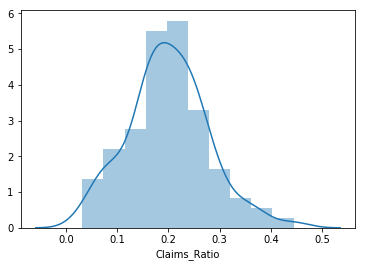

In [69]:
import seaborn as sns
sns.distplot(ratio_merged[ratio_merged.target == 1]['Claims_Ratio'])

The claims ratio has a gaussian distribution.<br>
Obviously, no specific transformation would be usefull on the target.

### Explore missing values

#### NaN distribution

In [70]:
# Look at the features having NaN in both train and test

train_nan_df = pd.DataFrame(train.isnull().sum())
train_nan_df.columns = ["Nb_NaN_train"]

test_nan_df = pd.DataFrame(test.isnull().sum())
test_nan_df.columns = ["Nb_NaN_test"]

all_df = pd.concat( (train_nan_df, test_nan_df), axis=1)
all_df

,Nb_NaN_train,Nb_NaN_test
ft_2_categ,0,0
EXPO,0,0
ft_4_categ,0,0
ft_5_categ,0,0
ft_6_categ,0,0
ft_7_categ,0,0
ft_8_categ,0,0
ft_9_categ,0,0
ft_10_categ,0,0
ft_11_categ,0,0


We see here that we have 3 features impacted by NaN values.<br>
Each of these features have NaN in the same proportion into test and train dataframes.
<br>
- superficief : it has NaN values. Generali provided a benchmark in which this features was very important. The 119 NaN imputation will be deterministic on the final model performance.
<br>
- ft_22_categ : this feature looks like the building construction year.
As in the previous point, this feature is one of the most importat feature in the Generali benchmark model. <b>As the ft_22_categ NaN represents 10% of the test data rows, applying NaN imputation will be deterministic in the model performance</b>.
<br>
- Insee : The last feature with NaN is not important in the Generali Model but we can guess that it will in our model.
As we are encouraged to enlarge the input features for our model we will merge them thanks to the INSEE code and so this feature will be indirectly really important for our model.
<br>

### Quantitative features distribution

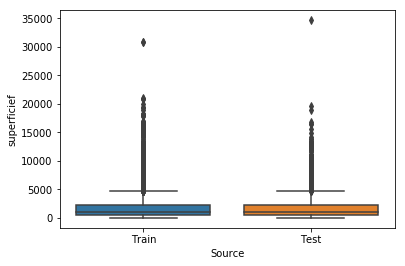

In [71]:
# Focus on superficief distribution
def boxplot_train_test(train, test, feature_name):
    col = feature_name
    df=pd.DataFrame({col:pd.concat((train[col],test[col]),0)})
    df["Source"]= "Train"
    df.reset_index(inplace=True)
    df.loc[df.index>=train.shape[0],"Source"]="Test"
    
    # boxplot distribution
    sns.boxplot(
    x='Source',
    y=col,
    data=df)
    
boxplot_train_test(train, test, "superficief")    


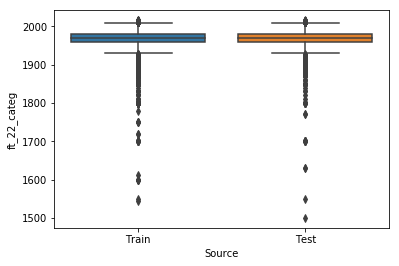

In [72]:
boxplot_train_test(train, test, "ft_22_categ")   

Both superficief and ft_22_categ have really similar distributions.<br>
We can gather values over 15000 for superficief and values under 1800 for ft_22_categ to artificially create density.

### Values lists

In [73]:
# Get unique values per column
col_names = combine.columns.values.tolist()
df = pd.DataFrame(combine.apply(lambda x : list(dict.fromkeys(x))))
df = df.transpose()
df.columns = col_names
df.head()

,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,ft_12_categ,ft_13_categ,ft_14_categ,ft_15_categ,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee
0,"[2014, 2013, 2015, 2016, 2012]","[1.0, 0.246575342, 0.99726776, 0.081967213, 0....","[0, 1]","[V, N, O]","[N, V, O]","[1, V, 2, 3]","[O, V, N]","[1, V, 2, 3]","[O, V, N]","[N, V, O]","[N, V, O]","[N, V, O]","[N, V, O]","[AUTRE, V]","[IDENTIQUE, V]","[V, N, O]","[base, effpi, V, pi, eff]","[2, 1]","[1351.0, 1972.0, 1630.0, 532.0, 1050.0, 2039.0...","[4, 2, 3, 1]","[2012.0, 1980.0, nan, nan, 1972.0, 1960.0, nan...","[0.0, 0.3, 0.6, V, 1.0, 2.0, 1.5]","[ 2, ., 4, 3, 5, 8, >=10, ...","[65440, 14341, 75109, 92004, 59340, 13206, 330..."


We see here that there is a "V" value that is present in a huge set of features.

### Categorical features distribution

<b>Analyze "V" values into the datasets</b>

In [74]:
# Function looking for a specific value into columns
# return these columns
def get_columns_having(l_pattern, df):
    pattern_mask = df.isin([l_pattern]).any()
    # return colname list
    return df.loc[:,pattern_mask].columns


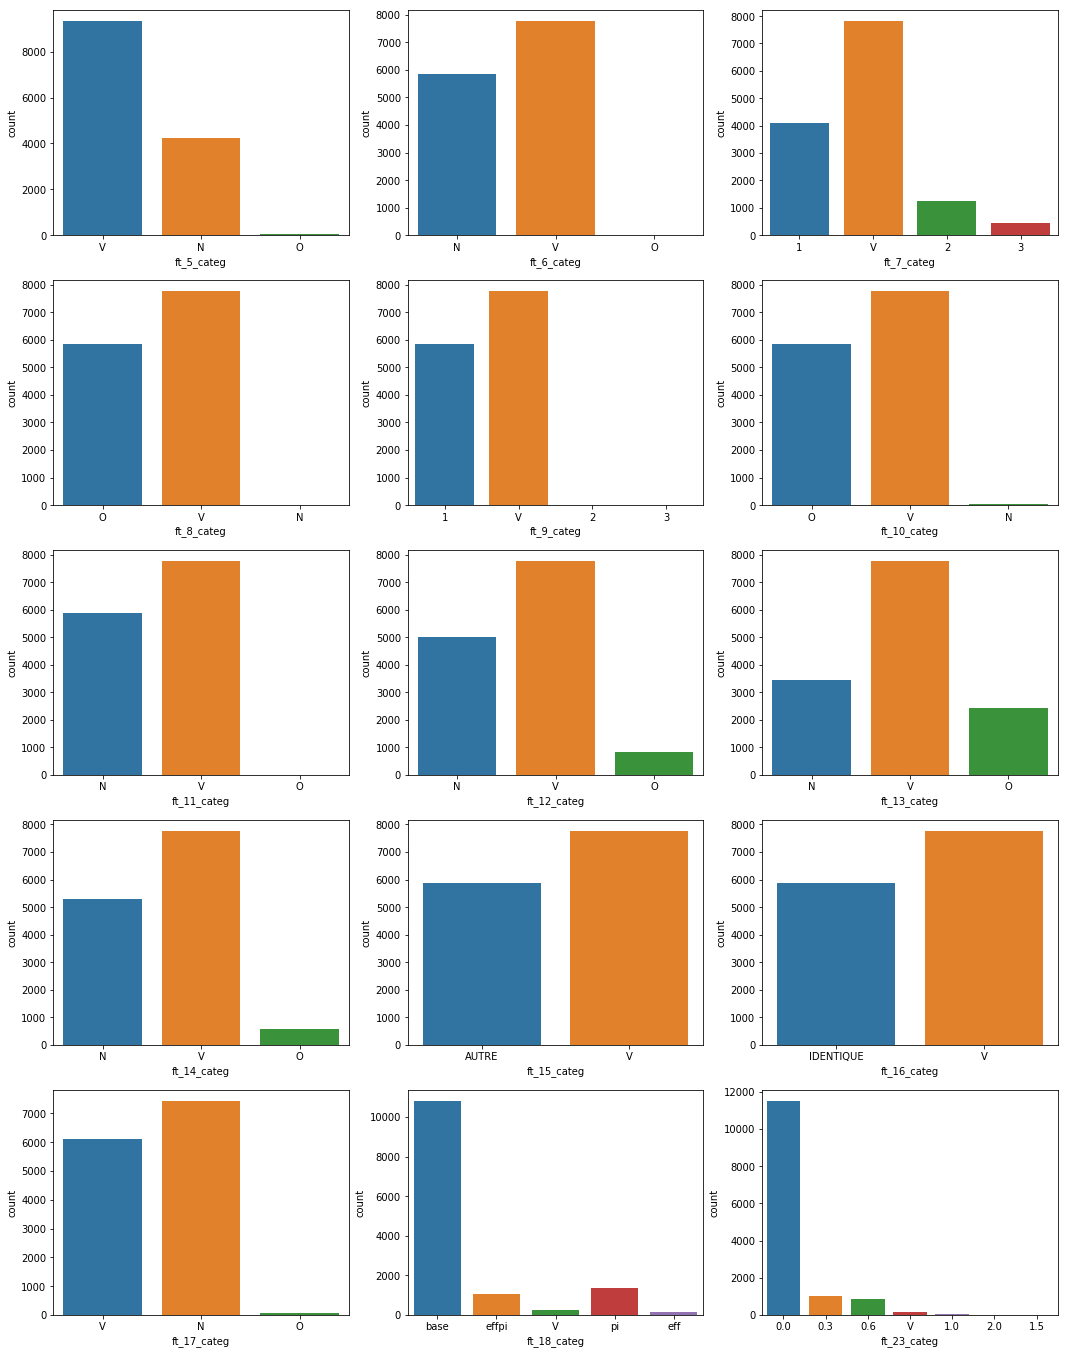

In [75]:
# Function to plot seaborn countplot :
#   - df          : dataframe source
#   - column_list : column list to plot
#   - n_wide      : how many plot by line 

def countplot_features(df, column_list, n_wide=1):
    fig, ax = plt.subplots(int(len(column_list)/n_wide), n_wide, figsize = (18,24))
    for i, col in enumerate(column_list) :
        plt.sca(ax[int(i/n_wide), (i%n_wide)])
        sns.countplot(x=col, data=df)
    
V_column_list = get_columns_having("V", combine)
countplot_features(combine, V_column_list, 3)

The "V" value is a very recurrent value. It is the main value for 12 features.<br>
So in order to keep information, we won't remove these features and we will keep it as a specific value and not like a NaN.<br>
<br>
Moreover, we have <b>under populated categories</b> like : 
- all values above 1 for the <b>ft_23_categ</b> feature 
- or categories 2 and 3 for <b>ft_9_categ</b>


<b>Analyze feature without "V" values</b>

<b>ft_2_categ :</b> Insured period

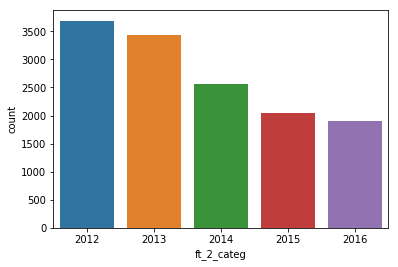

In [76]:
sns.countplot(x="ft_2_categ", data=combine)

Seems to be the building year, we have some top values for specific years, 1960 and 1980 are ones of these years.

<b>ft_24_categ : </b> Anonymised feature

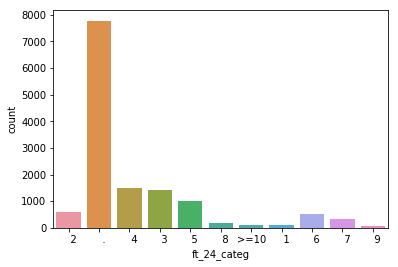

In [77]:
sns.countplot(x="ft_24_categ", data=combine)

For this feature we have a high ratio of the "."<br>
We guess it is equivalent to the "V" value and one more time we have a high ratio of missing values.<br>
We still keep the feature even if it would be difficult to extract data from this feature.<br>
<br>
About values above 8 we have weak number of rows and could gather all above 8 values to generalize data.

### Search for ft_18_categ interpretation

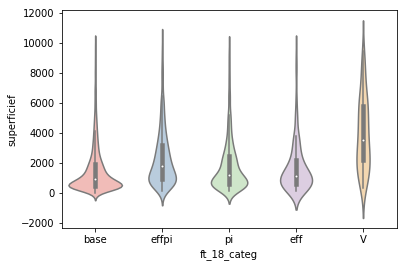

In [78]:
sns.violinplot(x="ft_18_categ", y="superficief", data=combine.loc[combine["superficief"]<=10000,["ft_18_categ","superficief"]], palette="Pastel1")

We cannot clearly establish an interpretation to the ft_18_categ meaning.<br>


(267, 24)

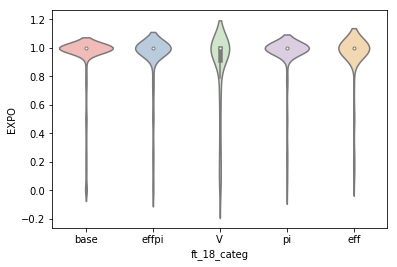

In [86]:
pd.options.display.float_format = '{:,.2f}'.format
sns.violinplot(x="ft_18_categ", y="EXPO", data=combine.loc[:,["ft_18_categ","EXPO"]], palette="Pastel1")


It appears here that rows having a "V" value in the ft_18_categ column are more suggest to shorter exposure time.<br>
It is still hard to explain what it can mean but we note the point.<br>
Moreover there are some rows with an exposure time of0 that doesn't seems to be possible.

In [106]:
#train_target["EXPO"] = train_target["EXPO"].str.replace(",",".").astype(float)
train_target.loc[train_target["EXPO"]==0.00,"target"].mean()


0.13636363636363635

The claim ratio is quite low for rows having exposure time to 0.<br>
We have no idea to the real value, we will create a new column Is_EXPO_0 and reset these rows to 1 for the EXPO variable.

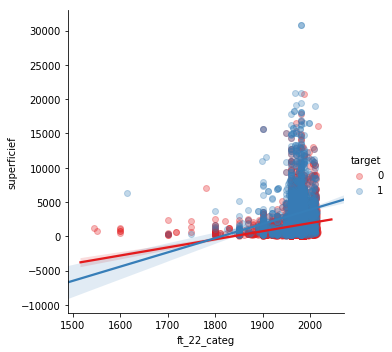

In [23]:
sns.lmplot(x='ft_22_categ', y='superficief', data=train_target, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

In [24]:
print( "superficief quantile at 97.5% : "+str(train_target["superficief"].quantile(0.975)))
tt = train_target.loc[train_target["superficief"] > train_target["superficief"].quantile(0.975), "target"]
print("claims ratio over the previous quantile :" + str(sum(tt)/tt.shape[0]))

superficief quantile at 97.5% : 8360.0
claims ratio over the previous quantile :0.6349206349206349


We have here very strange data, some building have been built more than 200 years before.<br>
Their superficief are very very small.<br>
We observe here that building older than 200 years have low risk to generate claim and<br>
when building wider than the 97.5 quantile building are bond to generate claims at 63.5%.

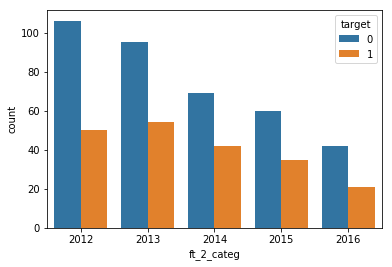

In [28]:
import seaborn as sns
#train_target["ft_2_categ"] = train_ft_2_categ.ft_2_categ
train_target["Dept_code"] = train_target["Insee"].str[:2]

sns.countplot(x="ft_2_categ", hue="target", data=train_target[train_target["Dept_code"]=='75'])

We can see here that year to year we have differents global claim rates and contracts volume.<br><br>
What about the superficief influence ?<br>
Generali provided a benchmark in which this feature is one of the main features. It could be interesting to go dig its data distribution and its target relation.

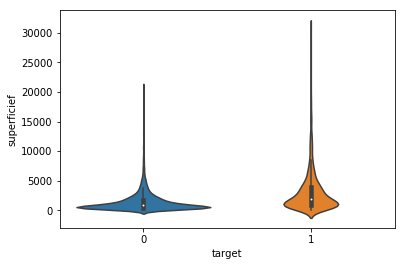

In [29]:
# Superficief distribution regarding target values
sns.violinplot(
    x='target',
    y='superficief',
    data=train_target)

C:\Users\query\Anaconda3_New\envs\env3.6_GPU\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\query\Anaconda3_New\envs\env3.6_GPU\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\query\Anaconda3_New\envs\env3.6_GPU\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\query\Anaconda3_New\envs\env3.6_GPU\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


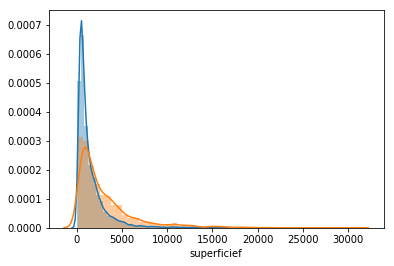

In [30]:
# Binarize superficief to distinguish target relation for local set of values
bins_size = 50
sns.distplot(train_target.loc[train_target["target"]==0,"superficief"], bins=bins_size);
sns.distplot(train_target.loc[train_target["target"]==1,"superficief"], bins=bins_size);


With 50 BINS we have enough sets to evaluate trustable target_mean values. <br>
We clearly identify here superficief for which target take different values.

## Look for missing data shape<p id="chapII"></p>


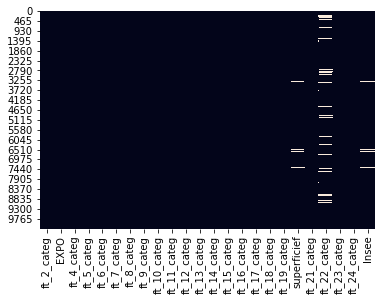

In [25]:
# Plot missing data
sns.heatmap(train.isnull(), cbar=False)

##  Reorganize data distribution <p id="chapIII"></p>

In [26]:
# Merge under represented category
def merge_generali_data(df):
    #"ft_24_categ"
   
    df.loc[df["ft_24_categ"].isin(["8","9",">=10"]), "ft_24_categ"] = ">=8"
    
    #"ft_23_categ"
    df.loc[df["ft_23_categ"]=="1.5", "ft_23_categ"] = "1"
    df.loc[df["ft_23_categ"]=="2", "ft_23_categ"] = "1"
    
    #"ft_9_categ"
    df.loc[df["ft_9_categ"]=="3", "ft_9_categ"] = "2"
    
    #"superficief"
    q975 = df["superficief"].quantile(0.975)
    df["superficief>q975"] = 0
    df.loc[df["superficief"]>=q975, "superficief>q975"] = 1
    df.loc[df["superficief"]>=q975, "superficief"] = q975
    
    #"superficief"
    df.loc[df["ft_22_categ"]<=1800, "ft_22_categ"] = 1800
    
    return df

train = merge_generali_data(train)
test = merge_generali_data(test)    


## Clean up rows not having Insee values<p id="chapIV"></p>

In [27]:
from ngc_claims_functions import *
# First remove rows without Insee value
# All the following analyze will be done with data having geographical data
y_train = y_train[with_Insee_mask(train)]
y_train.reset_index(inplace=True)

train = train[with_Insee_mask(train)]
train.reset_index(inplace=True)

test = test[with_Insee_mask(test)]
test.reset_index(inplace=True)

## Transform category to dummies column<p id="chapV"></p>

In [28]:
#Transform and create features with category
def dummies(train, test, columns = None):
    if columns != None:
        for column in columns:
            train[column] = train[column].apply(lambda x: str(x))
            test[column] = test[column].apply(lambda x: str(x))
            good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
            train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
            test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
            del train[column]
            del test[column]
    return train, test




In [30]:
# Define a categ type column list to transform with dummies values
categ_col_list = [col for col in train.columns if 'categ' in col]
categ_col_list.remove("ft_22_categ")

# Rework ft_24_categ data
train["ft_24_categ"] = train["ft_24_categ"].str.replace(" ","")
test["ft_24_categ"] = test["ft_24_categ"].str.replace(" ","")


In [31]:
# Encode categorial features
train_dummies, test_dummies = dummies(train, test , columns = categ_col_list)

# Fix Expo column type
train_dummies["EXPO"] = train_dummies["EXPO"].str.replace(",",".").astype(float)

# Get columns having null values
ft_22_categ = train_dummies["ft_22_categ"].copy()
superficief = train_dummies["superficief"].copy()
insee = train_dummies["Insee"].copy()

# Get index for each column null values
ft_22_categ_null_idx = train_dummies["ft_22_categ"].isnull()
superficief_null_idx = train_dummies["superficief"].isnull()
Insee_null_idx = train_dummies["Insee"].isnull()

# Delete columns having null values before imputing values
del  train_dummies["ft_22_categ"]
del  train_dummies["superficief"]
#del  train_dummies["Insee"]



## Impute [ft_22_categ / superficief] NaN<p id="chapVI"></p>


<font size=3.5><strong>Impute Generali missing data</strong></font>

----------------------

<font size=2.5><strong>Use simple Knn model</strong></font> 

In [32]:
Insee = train_dummies["Insee"]
del train_dummies["Insee"]
del train_dummies["with_Insee"]

In [58]:
from ngc_claims_functions import *
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.ensemble import RandomForestRegressor

# Define train target to impute
train_ft_22_categ = train_dummies.loc[(ft_22_categ_null_idx==False),"EXPO":]
y_ft_22_categ = ft_22_categ[(ft_22_categ_null_idx==False)]
                            

def eval_regressor(model, k_folds, train_data, train_target):
    num_val_samples = len(train_ft_22_categ) // k 
    all_scores = [] 
    
    for i in range(k_folds): 
        #print('processing fold #', i) 
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
        val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples] 
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0) 
        partial_train_targets = np.concatenate([train_target[:i * num_val_samples], train_target[(i + 1) * num_val_samples:]], axis=0) 
    
        model.fit(partial_train_data, partial_train_targets) 
        pred = model.predict(val_data)
        error = sqrt(mean_squared_error(val_targets,pred)) #calculate rmse
        all_scores.append(error)
                            
    #print(np.std(all_scores))
    #np.mean(all_scores)
    return model.__class__.__name__, np.std(all_scores), np.mean(all_scores)
        

# Evaluate perf
models=list()
params=list()
stds=list()
means=list()
# Impute with KNN
for i in range(3, 45):
    knni = KNeighborsRegressor(n_neighbors=i)
    model_name, std, mean = eval_regressor(knni, 5, train_ft_22_categ, y_ft_22_categ)
    models.append(model_name)
    params.append(i)
    stds.append(std)
    means.append(mean)
    print("Model name : " + model_name + " param :"+str(i)+" rmse : "+ str(mean) + " std : "+str(std))

# Impute with a random Forest
for n_estimator_i in range(200,1000,100):
    for depth_j in range(6, 16, 2):
        rf = RandomForestRegressor(n_estimators=n_estimator_i, criterion="mse", 
                                   max_depth=depth_j, oob_score=True, n_jobs=-1)
        model_name, std, mean = eval_regressor(rf, 5, train_ft_22_categ, y_ft_22_categ)
        models.append(model_name)
        params.append(i)
        stds.append(std)
        means.append(mean)
        print("Model name : " + model_name + " param n_estimator:"+str(n_estimator_i)+ " & depth_j : "+str(depth_j)+" rmse : "+ str(mean) + " std : "+str(std))

    

Model name : KNeighborsRegressor param :3 rmse : 29.44365355882652 std : 0.5235882036677895
Model name : KNeighborsRegressor param :4 rmse : 28.70231490670825 std : 0.7117816242784806
Model name : KNeighborsRegressor param :5 rmse : 28.185735725107072 std : 0.792077461392185
Model name : KNeighborsRegressor param :6 rmse : 28.013759944195062 std : 0.685032436067246
Model name : KNeighborsRegressor param :7 rmse : 27.633991008167406 std : 0.786331932406052
Model name : KNeighborsRegressor param :8 rmse : 27.48400219392439 std : 0.805511487486007
Model name : KNeighborsRegressor param :9 rmse : 27.399200508611177 std : 0.9150120574847036
Model name : KNeighborsRegressor param :10 rmse : 27.364511405547898 std : 0.9283127434886664
Model name : KNeighborsRegressor param :11 rmse : 27.26045972018223 std : 0.9262439523265957
Model name : KNeighborsRegressor param :12 rmse : 27.158049274056463 std : 0.9795477400443133
Model name : KNeighborsRegressor param :13 rmse : 27.1040286603701 std : 0.

Model name : RandomForestRegressor param n_estimator:900 & depth_j : 8 rmse : 26.09000031962548 std : 0.6918434889025776
Model name : RandomForestRegressor param n_estimator:900 & depth_j : 10 rmse : 26.08788032978837 std : 0.6726931378507693
Model name : RandomForestRegressor param n_estimator:900 & depth_j : 12 rmse : 26.178804622079475 std : 0.6324850960586166
Model name : RandomForestRegressor param n_estimator:900 & depth_j : 14 rmse : 26.39828462583474 std : 0.6575239795776395


The best estmator for the ft_22_categ is a RandomForestRegressor with n_estimator:400 and trees depth at : 8

In [60]:
# Let's try with KNN & 3 neighbors

# Use random forest 
rf = RandomForestRegressor(n_estimators=400, criterion="mse", 
                                   max_depth=8, oob_score=True, n_jobs=-1)
# predict ft_22_categ null values
rf.fit(  train_dummies.loc[(ft_22_categ_null_idx==False),"EXPO":],  ft_22_categ[(ft_22_categ_null_idx==False)]  )
pred_ft_22_categ = rf.predict(train_dummies.loc[ft_22_categ_null_idx,"EXPO":])

knn = KNeighborsRegressor(n_neighbors=3)
# predict superficief_null_idx null values
knn.fit(  train_dummies.loc[(superficief_null_idx==False),"EXPO":],  superficief[(superficief_null_idx==False)]  )
pred_superficief = knn.predict(train_dummies.loc[superficief_null_idx,"EXPO":])

# Concat all resulting rows
ft_22_categ[ft_22_categ_null_idx] = pred_ft_22_categ.tolist().copy()
superficief[superficief_null_idx] = pred_superficief.tolist().copy()  



# Integrate all the 3 columns into the "train_dummies" dataframe
train_dummies = pd.concat( (train_dummies, ft_22_categ, superficief ) , axis=1)



In [61]:
train_dummies.columns

Index(['index', 'EXPO', 'superficief>q975', 'ft_2_categ_2014',
       'ft_2_categ_2013', 'ft_2_categ_2015', 'ft_2_categ_2016',
       'ft_2_categ_2012', 'ft_4_categ_0', 'ft_4_categ_1', 'ft_5_categ_V',
       'ft_5_categ_N', 'ft_5_categ_O', 'ft_6_categ_N', 'ft_6_categ_V',
       'ft_6_categ_O', 'ft_7_categ_1', 'ft_7_categ_V', 'ft_7_categ_2',
       'ft_7_categ_3', 'ft_8_categ_O', 'ft_8_categ_V', 'ft_8_categ_N',
       'ft_9_categ_1', 'ft_9_categ_V', 'ft_9_categ_2', 'ft_10_categ_O',
       'ft_10_categ_V', 'ft_10_categ_N', 'ft_11_categ_N', 'ft_11_categ_V',
       'ft_11_categ_O', 'ft_12_categ_N', 'ft_12_categ_V', 'ft_12_categ_O',
       'ft_13_categ_N', 'ft_13_categ_V', 'ft_13_categ_O', 'ft_14_categ_N',
       'ft_14_categ_V', 'ft_14_categ_O', 'ft_15_categ_AUTRE', 'ft_15_categ_V',
       'ft_16_categ_IDENTIQUE', 'ft_16_categ_V', 'ft_17_categ_V',
       'ft_17_categ_N', 'ft_17_categ_O', 'ft_18_categ_base',
       'ft_18_categ_effpi', 'ft_18_categ_pi', 'ft_18_categ_eff',
       'ft_18_cate

## Look for hidden signal<p id="chapVII"></p>

<font size=3.5><strong>Create new features </strong></font>

----------------------

<font size=2.5><strong>Try to bring back information from hidden data</strong></font> 

We suppose in that part that contrat churn is low in the building insurance activity. So we estimate that the "Expo" contract duration is a end of year status.

In [62]:
# Add the building Age with ft_2_categ that is the insured period during which we want to predict a claim propbability
# and ft_22_categ that seems to be the building year.
train = train[with_Insee_mask(train)]
train_dummies["Age"] = train["ft_2_categ"].astype(int) - train_dummies["ft_22_categ"]


In [63]:
pd.options.display.float_format = '{:,.3f}'.format


# EXPO value represent the time spent during the insurance contract year 
# We will suppose low rate of churn and so that the value represents a end of year status
# by this way we will try to catch "seasonality"

# First create 12 features 
monthFeaturesList = ['Is_Exposed_M_'+str(x) for x in range(1, 13)]
 

# Add the new columns into the train_dummies dataframe
df_months = pd.DataFrame(index=range(0,train_dummies.shape[0]), columns=monthFeaturesList)
df_months = df_months.fillna(0)
train_dummies = pd.concat((train_dummies, df_months), axis = 1)

# Function to calculate a given Month exposure
def set_month_dummies(row):
        
    for c_month_nb in range(1,13):
        # Get month exposed from the end of the year
        if c_month_nb/12  <= row["EXPO"]:
            row['Is_Exposed_M_'+str(12-c_month_nb+1)] = 1
    return row    


# Affect "Month Exposure" dummy values
train_dummies = train_dummies.apply(set_month_dummies, axis=1)

train_dummies[monthFeaturesList+["EXPO"]].head()

,Is_Exposed_M_1,Is_Exposed_M_2,Is_Exposed_M_3,Is_Exposed_M_4,Is_Exposed_M_5,Is_Exposed_M_6,Is_Exposed_M_7,Is_Exposed_M_8,Is_Exposed_M_9,Is_Exposed_M_10,Is_Exposed_M_11,Is_Exposed_M_12,EXPO
0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.247
4,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Add external data<p id="chapVIII"></p>
<br>
<font size=3.5><strong>Add the Insee "Commune" data </strong></font>

----------------------

<font size=2.5><strong> Use data.gouv.fr open data to collect social data</strong></font> 
<b>data source :</b> https://www.data.gouv.fr/fr/datasets/data-insee-sur-les-communes/ diffusé le 12 décembre 2014 

In [64]:
# Read open data
commune_df = pd.read_excel("./MDB-INSEE-V2.xls")
commune_df.info()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36677 entries, 0 to 36676
Columns: 101 entries, CODGEO to CP
dtypes: float64(51), int64(35), object(15)
memory usage: 28.3+ MB


In [65]:
commune_df.describe()

,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,REG,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB
count,"36,676.000","36,676.000","36,676.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,662.000","36,662.000","36,662.000","36,565.000","36,565.000","36,565.000","36,565.000","36,565.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,676.000","36,676.000","36,676.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,677.000","36,676.000","36,677.000","36,677.000"
mean,0.067,99.501,99.502,99.505,100.000,54.708,100.000,0.043,100.000,0.115,49.448,16.698,16.609,8.061,8.061,0.313,2.528,100.000,0.077,100.000,0.060,"1,640.357",55.138,-0.500,663.617,663.749,363.475,799.182,79.963,55.470,"1,604.442","1,644.076","1,547.716","1,936.272","1,255.520",135.121,40.358,37.207,10.546,14.311,8.752,0.557,1.442,2.218,4.535,"10,353.941","10,259.099",10.994,21.208,12.467,8.664,9.051,11.167,21.285,12.522,8.688,9.114,"41,466.785",7.685,640.955,561.008,79.947,79.561,0.477,16.388,0.218,25.225,0.027,58.017,-6.068,-30.133,-30.133,"10,306.520",0.805,10.048,3.321,10.573,"3,242.189","4,601.875","1,866.032","8,030.740","80,789.413",71.106,0.035,14.852,15.052
std,1.921,"1,361.510","2,232.827",428.065,10.523,23.519,"1,353.117",0.578,430.194,0.571,25.441,13.015,1

<b>Missing values : </b>
- First fill column having only one missing value with their mode 
- then all others with their mean

In [66]:
# "Commune" having null values
null_col_list = commune_df.columns[commune_df.isnull().sum()>0]
commune_df.loc[:,null_col_list].isnull().sum()

Nb Pharmacies et parfumerie                         1
Dynamique Entrepreneuriale                          1
Dynamique Entrepreneuriale Service et Commerce      1
Nb Entreprises Secteur Services                     1
Nb Entreprises Secteur Commerce                     1
Nb Entreprises Secteur Construction                 1
Nb Entreprises Secteur Industrie                    1
Nb Création Enteprises                              1
Nb Création Industrielles                           1
Nb Création Construction                            1
Nb Création Commerces                               1
Nb Création Services                                1
Nb Atifs                                           15
Nb Actifs Salariés                                 15
Nb Actifs Non Salariés                             15
Nb Logement Secondaire et Occasionnel             112
Nb Hotel                                          112
Capacité Hotel                                    112
Nb Camping                  

In [67]:
# Let's check informations about incomplete cols
commune_df[null_col_list].describe()

,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Score Croissance Entrepreneuriale
count,"36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,676.000","36,662.000","36,662.000","36,662.000","36,565.000","36,565.000","36,565.000","36,565.000","36,565.000","36,676.000","36,676.000","36,676.000","36,676.000"
mean,0.067,99.501,99.502,40.358,37.207,10.546,14.311,8.752,0.557,1.442,2.218,4.535,640.955,561.008,79.947,79.561,0.477,16.388,0.218,25.225,10.048,3.321,10.573,0.035
std,1.921,"1,361.510","2,232.827",878.278,852.605,98.552,203.950,161.688,7.820,17.330,32.648,104.932,"6,041.419","5,303.438",750.047,612.642,8.196,431.342,0.959,192.857,150.352,41.168,142.166,0.570
min,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,19.000,5.000,2.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,67.000,48.000,15.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,31.000,11.000,5.000,4.000,3.000,3.000,1.000,0.000,0.000,0.000,1.000,151.000,119.000,30.000,21.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003
75%,0.000,63.000,35.000,15.000,13.000,8.000,8.000,4.000,0.000,1.000,1.000,2.000,375.000,312.000,64.000,50.000,0.000,0.000,0.000,0.000,3.000,1.000,3.000,0.016
max,353.000,"245,985.000","408,150.000","159,828.000","156,371.000","16,823.000","36,275.000","28,917.000","1,385.000","2,822.000","5,597.000","19,113.000","991,003.000","860,152.000","130,851.000","75,725.000","1,482.000","78,165.000",56.000,"14,475.000","24,329.000","6,778.000","22,285.000",100.000


In [68]:
# Fill all columns having one null value with the mode 
one_null_col_list = commune_df.columns[commune_df.isnull().sum()==1]
commune_df.loc[:, one_null_col_list] = commune_df.loc[:, one_null_col_list].apply(lambda x:x.fillna(x.value_counts().index[0]))


In [69]:
# Deal with all other incomplete columns and impute them with local mean values
null_col_list = commune_df.columns[commune_df.isnull().sum()>0]
commune_df.loc[:, null_col_list] = commune_df.loc[:, null_col_list].apply(lambda x:x.fillna(x.mean()))


In [70]:
# Check if we have no more missing values 
commune_df.columns[commune_df.isnull().sum()>0]

Index([], dtype='object')

<font size=3.5><strong>Merge Commune data to Generali </strong></font>

----------------------

In [71]:
# Encode categorical features "Orientation Economique", "Urbanité Ruralité"
# And keep all other quantitative features

# Initialize commune_df_dummies with quatitative features
commune_df_dummies = commune_df.select_dtypes(exclude=[object])

# Then complete encoding categorical features selected
for column in ["Orientation Economique", "Urbanité Ruralité"]:
            commune_df[column] = commune_df[column].apply(lambda x: str(x).rstrip().replace(" ",""))
            new_cols = [column+'_'+i for i in commune_df[column].unique()]
            commune_df_dummies = pd.concat((commune_df_dummies, pd.get_dummies(commune_df[column], prefix = column)[new_cols]), axis = 1)

commune_df_dummies = pd.concat((commune_df["CODGEO"], commune_df_dummies), axis = 1)            
commune_df_dummies.columns            

Index(['CODGEO', 'Nb Pharmacies et parfumerie', 'Dynamique Entrepreneuriale',
       'Dynamique Entrepreneuriale Service et Commerce',
       'Synergie Médicale COMMUNE', 'Indice Fiscal Partiel', 'Score Fiscal',
       'Indice Evasion Client', 'Score Evasion Client',
       'Indice Synergie Médicale', 'Score Synergie Médicale', 'REG',
       'Nb Omnipraticiens BV', 'Nb Infirmiers Libéraux BV',
       'Nb dentistes Libéraux BV', 'Nb pharmaciens Libéraux BV',
       'Densité Médicale BV', 'Score équipement de santé BV',
       'Indice Démographique', 'Score Démographique', 'Indice Ménages',
       'Score Ménages', 'Population', 'Evolution Population',
       'Evolution Pop %', 'Nb Ménages', 'Nb Résidences Principales',
       'Nb propriétaire', 'Nb Logement', 'Nb Résidences Secondaires',
       'Nb Log Vacants', 'Nb Occupants Résidence Principale', 'Nb Femme',
       'Nb Homme', 'Nb Mineurs', 'Nb Majeurs', 'Nb Etudiants',
       'Nb Entreprises Secteur Services', 'Nb Entreprises Secteur 

In [72]:
###########################################################################################
# First we checked that CODGEO is indeed the Insee code.
# To validate this hypothese we checked the example of L'Abergement-Clémenciat on wikipedia 
# here : "https://fr.wikipedia.org/wiki/L%27Abergement-Cl%C3%A9menciat"
###########################################################################################
train_dummies["Insee"] = Insee
# So we can join dataframes together directly
train_complete_df = train_dummies.merge(commune_df_dummies, how='left', left_on='Insee', right_on='CODGEO')

# Then list rows that did not found matching data into the "commune" dataset 
train_complete_df.loc[train_complete_df.CODGEO.isnull(),["Insee"]].Insee.str[0:2].value_counts()



13    971
75    574
69     34
34     18
38     15
83      9
62      7
73      6
06      4
30      2
59      1
57      1
74      1
33      1
44      1
40      1
67      1
68      1
15      1
77      1
11      1
2A      1
Name: Insee, dtype: int64

Data are missing mainly on Bouche-du-Rhône (13) and Paris (75).

<font size=3.5><strong>Impute CODGEO with KNN Classifier</strong></font>

----------------------

In [73]:
# Use here KNN to fill na
# K = 3
knn_class = KNeighborsClassifier(n_neighbors=3)  

# Define binary columns to apply knn classifiers on
boolean_col_mask = [len(train_complete_df[x].fillna(0).unique())<=2 for x in train_complete_df.columns]
boolean_cols = train_complete_df.columns[boolean_col_mask]
# Filter out columns without any Null Values
boolean_cols = boolean_cols[train_complete_df[boolean_cols].isnull().sum()>0]

# Not boolean ones for regressors
not_boolean_col_mask = list(map(lambda item: not item, boolean_col_mask))
not_boolean_cols = train_complete_df.columns[not_boolean_col_mask]
# Filter out columns without any Null Values
not_boolean_cols = not_boolean_cols[train_complete_df[not_boolean_cols].isnull().sum()>0]


########################################################################################
# Fill Na for all binary factor columns with knn classifier
# We fill "Commune" data that has not been merged because 
# the original dataset has no CODGEO data recorded so no index to join to "Commune" data

# For each boolean cols, impute NaN with a Classifier  
for boolean_col in boolean_cols:  
    print(boolean_col)
    
    # Define mask for rows having NaN
    col_null_idx = train_complete_df[boolean_col].isnull()
    #train_complete_df.loc[(col_null_idx==False), boolean_col]

    # Fit model on rows having CODGEO, then predict on col with null CODGEO values
    knn_class.fit(  train_complete_df.loc[(col_null_idx==False), "EXPO":"superficief"],  train_complete_df.loc[(col_null_idx==False), boolean_col]  )
    pred = knn_class.predict(train_complete_df.loc[col_null_idx, "EXPO":"superficief"])
        
    # Concat all resulting rows
    train_complete_df.loc[col_null_idx, boolean_col] = pred.tolist().copy()

Orientation Economique_BassinIndustriel
Orientation Economique_BassinRésidentiel
Orientation Economique_BassinUrbain
Orientation Economique_Bassindiversifié
Orientation Economique_BassinsAgroalimentaire
Urbanité Ruralité_Comrurale<2000mhabts
Urbanité Ruralité_Com<50mhabts
Urbanité Ruralité_Comrurale>2000habts
Urbanité Ruralité_Com<10mhabts
Urbanité Ruralité_Com<200mhabts
Urbanité Ruralité_Com>200mhabts


In [74]:
# Once again we use here KNN to fill na
# K = 3
knn_class = KNeighborsClassifier(n_neighbors=3)

col = "CODGEO"
col_null_idx = train_complete_df.CODGEO.isnull()

# predict current col null values
knn_class.fit(  train_complete_df.loc[(col_null_idx==False), "EXPO":"superficief" ],  train_complete_df.loc[(col_null_idx==False), col]  )
pred = knn_class.predict(train_complete_df.loc[col_null_idx,"EXPO":"superficief"])

# Concat all resulting rows
train_complete_df.loc[col_null_idx,col] = pred.tolist().copy()


<font size=3.5><strong>Impute quantitative features with KNN Regressor</strong></font>

----------------------

In [75]:
# Remove CODGEO from the Not Boolean feature list as it is a categorical feature
not_boolean_col_list = not_boolean_cols.tolist()
CODGEO_idx = not_boolean_col_list.index("CODGEO")
not_boolean_col_list.pop(CODGEO_idx)
not_boolean_cols = not_boolean_col_list

#Insee_idx = not_boolean_col_list.index("Insee")
#not_boolean_col_list.pop(Insee_idx)
#not_boolean_cols = not_boolean_col_list


In [76]:
knn_reg = KNeighborsRegressor(n_neighbors=5)


# For each boolean cols, impute NaN with a Classifier  
for not_boolean_col in not_boolean_cols:  
    #print(not_boolean_col)
    
    # Define mask for rows having NaN
    col_null_idx = train_complete_df[not_boolean_col].isnull()
    
    # Fit model on rows having CODGEO, then predict on col with null CODGEO values
    knn_reg.fit(  train_complete_df.loc[(col_null_idx==False), "EXPO":"superficief"],  train_complete_df.loc[(col_null_idx==False), not_boolean_col]  )
    pred = knn_reg.predict(train_complete_df.loc[col_null_idx, "EXPO":"superficief"])
        
    # Concat all resulting rows
    train_complete_df.loc[col_null_idx, not_boolean_col] = pred.tolist().copy()




In [77]:
train_complete_df.isnull().sum().sum()

0

No more null values

In [78]:
train_complete_df.head()

,index,EXPO,superficief>q975,ft_2_categ_2014,ft_2_categ_2013,ft_2_categ_2015,ft_2_categ_2016,ft_2_categ_2012,ft_4_categ_0,ft_4_categ_1,ft_5_categ_V,ft_5_categ_N,ft_5_categ_O,ft_6_categ_N,ft_6_categ_V,ft_6_categ_O,ft_7_categ_1,ft_7_categ_V,ft_7_categ_2,ft_7_categ_3,ft_8_categ_O,ft_8_categ_V,ft_8_categ_N,ft_9_categ_1,ft_9_categ_V,ft_9_categ_2,ft_10_categ_O,ft_10_categ_V,ft_10_categ_N,ft_11_categ_N,ft_11_categ_V,ft_11_categ_O,ft_12_categ_N,ft_12_categ_V,ft_12_categ_O,ft_13_categ_N,ft_13_categ_V,ft_13_categ_O,ft_14_categ_N,ft_14_categ_V,ft_14_categ_O,ft_15_categ_AUTRE,ft_15_categ_V,ft_16_categ_IDENTIQUE,ft_16_categ_V,ft_17_categ_V,ft_17_categ_N,ft_17_categ_O,ft_18_categ_base,ft_18_categ_effpi,ft_18_categ_pi,ft_18_categ_eff,ft_18_categ_V,ft_19_categ_2,ft_19_categ_1,ft_21_categ_4,ft_21_categ_2,ft_21_categ_3,ft_21_categ_1,ft_23_categ_0.0,ft_23_categ_0.3,ft_23_categ_0.6,ft_23_categ_1.0,ft_23_categ_2.0,ft_23_categ_1,ft_24_categ_2,ft_24_categ_.,ft_24_categ_4,ft_24_categ_3,ft_24_categ_5,ft_24_categ_8,ft_24_categ_>=8,ft_24_categ_1,ft_24_categ_6,ft_24_categ_7,ft_24_categ_9,ft_22_categ,superficief,Age,Is_Exposed_M_1,Is_Exposed_M_2,Is_Exposed_M_3,Is_Exposed_M_4,Is_Exposed_M_5,Is_Exposed_M_6,Is_Exposed_M_7,Is_Exposed_M_8,Is_Exposed_M_9,Is_Exposed_M_10,Is_Exposed_M_11,Is_Exposed_M_12,Insee,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,REG,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Orientation Economique_BassinIndustriel,Orientation Economique_BassinRésidentiel,Orientation Economique_BassinUrbain,Orientation Economique_Bassindiversifié,Orientation Economique_BassinsAgroalimentaire,Urbanité Ruralité_Comrurale<2000mhabts,Urbanité Ruralité_Com<50mhabts,Urbanité Ruralité_Comrurale>2000habts,Urbanité Ruralité_Com<10mhabts,Urbanité Ruralité_Com<200mhabts,Urbanité Ruralité_Com>200mhabts
0,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.0

In [79]:
train_complete_df["Pop_rate_per_Menage"] = train_complete_df["Population"] / train_complete_df["Nb Ménages"]
train_complete_df["Pop_rate_Logement"] = train_complete_df["Population"] / train_complete_df["Nb Logement"]
train_complete_df["Fem_per_Hom"] = train_complete_df["Nb Femme"] / train_complete_df["Nb Homme"]

train_complete_df["Hom_rate"] = train_complete_df["Nb Homme"] / train_complete_df["Population"]
train_complete_df["Etu_rate"] = train_complete_df["Nb Etudiants"] / train_complete_df["Population"]
train_complete_df["Com_per_Pop"] = train_complete_df["Nb de Commerce"] / train_complete_df["Population"]

train_complete_df["Actifs_rate"] = train_complete_df["Nb Actifs Salariés"] / train_complete_df["Population"]
train_complete_df["Camp_Travel_rate"] = train_complete_df["Capacité Camping"] / train_complete_df["Population"]

train_complete_df["Travel_rate"] = (train_complete_df["Capacité Hotel"] + train_complete_df["Capacité Camping"]) / train_complete_df["Population"]

train_complete_df["Crea_Entrp_per_Pop"] = train_complete_df["Nb Création Enteprises"] / train_complete_df["Population"]

train_complete_df["MSH_DpR"] = train_complete_df["Dep Moyenne Salaires Horaires"] / train_complete_df["Reg Moyenne Salaires Horaires"] 
train_complete_df["MSCH_DpR"] = train_complete_df["Dep Moyenne Salaires Cadre Horaires"] / train_complete_df["Reg Moyenne Salaires Cadre Horaires"] 
train_complete_df["MSPIH_DpR"] = train_complete_df["Dep Moyenne Salaires Prof Intermédiaire Horaires"] / train_complete_df["Reg Moyenne Salaires Prof Intermédiaire Horaires"]
train_complete_df["MSEH_DpR"] = train_complete_df["Dep Moyenne Salaires Employé Horaires"] / train_complete_df["Reg Moyenne Salaires Employé Horaires"]
train_complete_df["MSOH_DpR"] = train_complete_df["Dep Moyenne Salaires Ouvrié Horaires"] / train_complete_df["Reg Moyenne Salaires Ouvrié Horaires"]


<br><br><font size=3.5><strong>Add natural risk data </strong></font>

----------------------

<font size=2.5><strong> Data coming from ONRN (Observatoire National des Risques Naturels) </strong></font>
<br>http://www.onrn.fr/site/binaries/content/assets/documents/actualites/180404_indicateurs-onrn.pdf 


<br><font size=2.5><strong> a) Volumes exposed</strong></font>

#####  Nombre de maisons individuelles exposées à l’aléa retrait-gonflement d’argiles fort ou moyen, par commune 

In [80]:
RGA_FM_df = pd.read_excel("./Indicateur Nb maisons RGA FM.xlsx")
RGA_FM_df.rename({'Nb de maisons individuelles exposées à l’aléa RGA fort ou moyen':'NB_RGA_FM'}, axis='columns', inplace=True)

In [81]:
RGA_FM_df.head()

,INSEE,NOM_COM,NB_RGA_FM
0,01001,Abergement-Clémenciat,2
1,01002,Abergement-de-Varey,82
2,01004,Ambérieu-en-Bugey,979
3,01005,Ambérieux-en-Dombes,0
4,01006,Ambléon,0


In [82]:

train_complete_df = train_complete_df.merge(RGA_FM_df, how='left', left_on='Insee', right_on='INSEE', right_index=False)

In [83]:
del train_complete_df["INSEE"]

In [84]:
# fill with na commune with 0 --> no data means no house in the RGA FM
train_complete_df.fillna(0, inplace=True)

##### Population communale dans l’EAIP cours d’eau 
EAIP : Enveloppe Approchée d'inondation portentielle

In [85]:
EAIP_CE_df = pd.read_excel("./Indicateur Population EAIP CE.xls")
EAIP_CE_df.rename({"Population dans EAIP CE":"Pop_EAIP_CE"}, axis='columns', inplace=True)

In [86]:
EAIP_CE_df.head()

,INSEE_COM,NOM_COMM,CODE_DEPT,NOM_DEPT,CODE_REG,NOM_REGION,Pop_EAIP_CE
0,01001,L'ABERGEMENT-CLEMENCIAT,01,82,AIN,RHONE-ALPES,7.400
1,01002,L'ABERGEMENT-DE-VAREY,01,82,AIN,RHONE-ALPES,44.100
2,01004,AMBERIEU-EN-BUGEY,01,82,AIN,RHONE-ALPES,"6,269.300"
3,01005,AMBERIEUX-EN-DOMBES,01,82,AIN,RHONE-ALPES,1.500
4,01006,AMBLEON,01,82,AIN,RHONE-ALPES,100.900


In [87]:
train_complete_df = train_complete_df.merge(EAIP_CE_df[["INSEE_COM","Pop_EAIP_CE"]], how='left', left_on='Insee', right_on='INSEE_COM', right_index=False)

In [88]:
# Fill Na with 0 considering there is no EAIP_CE
train_complete_df.fillna(0, inplace=True)

In [89]:
del train_complete_df["INSEE_COM"]

##### Population communale dans l’EAIP submersion marine

In [90]:
EAIP_SM_df = pd.read_excel("./Indicateur Population EAIP SM.xls")
EAIP_SM_df.rename({"Population dans EAIP SM":"Pop_EAIP_SM"}, axis='columns', inplace=True)

In [91]:
EAIP_SM_df.head()

,INSEE_COM,NOM_COMM,CODE_DEPT,NOM_DEPT,CODE_REG,NOM_REGION,Pop_EAIP_SM
0,01001,L'ABERGEMENT-CLEMENCIAT,01,82,AIN,RHONE-ALPES,0.000
1,01002,L'ABERGEMENT-DE-VAREY,01,82,AIN,RHONE-ALPES,0.000
2,01004,AMBERIEU-EN-BUGEY,01,82,AIN,RHONE-ALPES,0.000
3,01005,AMBERIEUX-EN-DOMBES,01,82,AIN,RHONE-ALPES,0.000
4,01006,AMBLEON,01,82,AIN,RHONE-ALPES,0.000


In [92]:
train_complete_df = train_complete_df.merge(EAIP_SM_df[["INSEE_COM","Pop_EAIP_SM"]], how='left', left_on='Insee', right_on='INSEE_COM', right_index=False)


In [93]:
# Fill Na with 0 considering there is no EAIP_SM
train_complete_df.fillna(0, inplace=True)

In [94]:
del train_complete_df["INSEE_COM"]

##### Données mouvements de terrain (ONRN)

In [95]:
MVT_TERRAIN_df = pd.read_excel("Indicateur Nombre et types de mouvements de terrain.xls")
MVT_TERRAIN_df.head()

,INSEE_COM,NOM_COMM,Total,Gliss,Bloc,Coul,Eff,Eros
0,01001,L'ABERGEMENT-CLEMENCIAT,0,0,0,0,0,0
1,01002,L'ABERGEMENT-DE-VAREY,1,1,0,0,0,0
2,01004,AMBERIEU-EN-BUGEY,6,6,0,0,0,0
3,01005,AMBERIEUX-EN-DOMBES,0,0,0,0,0,0
4,01006,AMBLEON,0,0,0,0,0,0


In [96]:
train_complete_df = train_complete_df.merge(MVT_TERRAIN_df[["INSEE_COM","Total","Gliss","Bloc","Coul","Eff","Eros"]], how='left', left_on='Insee', right_on='INSEE_COM', right_index=False)

In [97]:
# Fill Na with 0 considering there is no MVT_TERRAIN_df
train_complete_df.fillna(0, inplace=True)

In [98]:
del train_complete_df["INSEE_COM"]

##### Indicateur Intensité Macrosismique maximale (ONRN)

In [99]:
Indensite_Macrosismique_df = pd.read_excel("Indicateur Intensité Macrosismique maximale.xlsx")
Indensite_Macrosismique_df.head()

,INSEE_COM,NOM_COM,INT_MAX_CALC,NB_TOTAL,INTERPOLEE
0,01001,L'ABERGEMENT-CLEMENCIAT,5.400,76,1.000
1,01002,L'ABERGEMENT-DE-VAREY,6.370,90,1.000
2,01004,AMBERIEU-EN-BUGEY,6.110,88,1.000
3,01005,AMBERIEUX-EN-DOMBES,5.420,72,1.000
4,01006,AMBLEON,6.820,106,1.000


In [100]:
train_complete_df = train_complete_df.merge(Indensite_Macrosismique_df[["INSEE_COM","INT_MAX_CALC","NB_TOTAL"]], how='left', left_on='Insee', right_on='INSEE_COM', right_index=False)

In [101]:
# Fill Na with 0 considering there is no Indensite_Macrosismique_df
train_complete_df.fillna(0, inplace=True)
del train_complete_df["INSEE_COM"]


<br><font size=2.5><strong> b) Sinistrality frequency and plublicly recognized catastrophes</strong></font>

#####  Fréquences moyennes des sinistres indemnisés par les assureurs au titre des garanties Tempête-Grêle-Poids de la neige (TGN) 

In [102]:
# Read Frequence of TGN and format Department Number to merge with on train data
FrequenceTGN_df = pd.read_excel("FrequenceTGN_ParDep_Cumul1987_2015.xlsx")
FrequenceTGN_df["Num_Dep"] = FrequenceTGN_df["Num_Dep"].astype(str).apply(lambda x : x.zfill(2))
FrequenceTGN_df.head()

,Num_Dep,Nom_Dep,Freq_TGN_1987_2015
0,01,AIN,4.675
1,02,AISNE,10.518
2,03,ALLIER,9.368
3,04,ALPES (HTE PROVENCE),4.133
4,05,ALPES (HAUTES),3.519


In [103]:
train_complete_df["Num_Dep"] = train_complete_df.CODGEO.str[:2]
train_complete_df = train_complete_df.merge(FrequenceTGN_df[["Num_Dep","Freq_TGN_1987_2015"]], how='left', left_on='Num_Dep', right_on='Num_Dep', right_index=False)

#####  Fréquences moyennes de sinistres d'inondations et reconnaissance de catastrophes naturelles

In [104]:
nbReco_inond_df = pd.read_excel("1-2.Indicateur_CCR_nbReco_inond2018.xls")
nbReco_inond_df.rename({'Nombre de reconnaissances Cat Nat  inondation':"Nb_reco_CatNat_inon"}, axis='columns', inplace=True)
nbReco_inond_df.loc[nbReco_inond_df["Nb_reco_CatNat_inon"] =='Pas de reconnaissance', "Nb_reco_CatNat_inon"] = '0'
nbReco_inond_df.head()


,Code INSEE,Commune,Nb_reco_CatNat_inon
0,01001,L'Abergement-Clémenciat,2
1,01002,L'Abergement-de-Varey,2
2,01004,Ambérieu-en-Bugey,3
3,01005,Ambérieux-en-Dombes,2
4,01006,Ambléon,1


In [105]:
FreqMoyenne_inond_df = pd.read_excel("5.Indicateur_CCR_FreqMoyenne_inond_1995_2014.xls")
FreqMoyenne_inond_df.rename({"Fréquence moyenne de sinistres inondation (tous types)":"Freq_moy_inon"}, axis='columns', inplace=True)
FreqMoyenne_inond_df.loc[FreqMoyenne_inond_df["Freq_moy_inon"]=="Pas de sinistre ou de risque répertoriés à CCR", "Freq_moy_inon"] = '0'
FreqMoyenne_inond_df.head()

,Code INSEE,Commune,Freq_moy_inon
0,01001,L'Abergement-Clémenciat,0
1,01002,L'Abergement-de-Varey,0
2,01004,Ambérieu-en-Bugey,0
3,01005,Ambérieux-en-Dombes,0
4,01006,Ambléon,0


In [106]:
# Merge inondation data to train data
train_complete_df = train_complete_df.merge(nbReco_inond_df[["Code INSEE","Nb_reco_CatNat_inon"]], how='left', left_on='Insee', right_on='Code INSEE', right_index=False)
del train_complete_df["Code INSEE"]
train_complete_df = train_complete_df.merge(FreqMoyenne_inond_df[["Code INSEE","Freq_moy_inon"]], how='left', left_on='Insee', right_on='Code INSEE', right_index=False)
del train_complete_df["Code INSEE"]

#####  Fréquences moyennes de sinistres de sécheresse et reconnaissance de catastrophes naturelles

In [107]:
nbReco_sechRGA_df = pd.read_excel("7.Indicateur_CCR_nbReco_sechRGA_2018.xls")
nbReco_sechRGA_df.rename({"Nombre de reconnaissances Cat Nat sécheresse":"Nb_reco_CatNat_sech"}, axis='columns', inplace=True)
nbReco_sechRGA_df.loc[nbReco_sechRGA_df["Nb_reco_CatNat_sech"] == "Pas de reconnaissance", "Nb_reco_CatNat_sech"]='0'
nbReco_sechRGA_df.head()

,Code INSEE,Commune,Nb_reco_CatNat_sech
0,01001,L'Abergement-Clémenciat,0
1,01002,L'Abergement-de-Varey,0
2,01004,Ambérieu-en-Bugey,1
3,01005,Ambérieux-en-Dombes,0
4,01006,Ambléon,0


In [108]:
FreqMoyenne_sechRGA_df = pd.read_excel("10.Indicateur_CCR_FreqMoyenne_sechRGA_1995_2014.xls")
FreqMoyenne_sechRGA_df.rename({"Fréquence moyenne de sinistres sécheresse":"Freq_moy_sech"}, axis="columns", inplace=True)
FreqMoyenne_sechRGA_df.loc[FreqMoyenne_sechRGA_df["Freq_moy_sech"]=="Pas de sinistre ou de risque répertoriés à CCR", "Freq_moy_sech"] = "0"
FreqMoyenne_sechRGA_df.head()

,Code INSEE,Commune,Freq_moy_sech
0,01001,L'Abergement-Clémenciat,0
1,01002,L'Abergement-de-Varey,0
2,01004,Ambérieu-en-Bugey,Entre 0 et 1 ‰
3,01005,Ambérieux-en-Dombes,0
4,01006,Ambléon,0


In [109]:
# Merge "sécheresse" data to the train dataframe
train_complete_df = train_complete_df.merge(nbReco_sechRGA_df[["Code INSEE","Nb_reco_CatNat_sech"]], how='left', left_on='Insee', right_on='Code INSEE', right_index=False)
del train_complete_df["Code INSEE"]

train_complete_df = train_complete_df.merge(FreqMoyenne_sechRGA_df[["Code INSEE","Freq_moy_sech"]], how='left', left_on='Insee', right_on='Code INSEE', right_index=False)
del train_complete_df["Code INSEE"]

#####  Fréquences moyennes de sinistres de type séisme

In [110]:
FreqMoyenne_seismes_df = pd.read_excel("14.Indicateur_CCR_FreqMoyenne_seismes_1995_2014.xls")
FreqMoyenne_seismes_df.rename({"Fréquence moyenne de sinistres séisme":"Freq_moy_sei"}, axis="columns", inplace=True)
FreqMoyenne_seismes_df.loc[FreqMoyenne_seismes_df["Freq_moy_sei"]=="Pas de sinistre ou de risque répertoriés à CCR", "Freq_moy_sei"]="0"
FreqMoyenne_seismes_df.head()

,Code INSEE,Commune,Freq_moy_sei
0,01001,L'Abergement-Clémenciat,0
1,01002,L'Abergement-de-Varey,0
2,01004,Ambérieu-en-Bugey,0
3,01005,Ambérieux-en-Dombes,0
4,01006,Ambléon,0


In [111]:
# Merge "séisme" data to the train dataframe
train_complete_df = train_complete_df.merge(FreqMoyenne_seismes_df[["Code INSEE","Freq_moy_sei"]], how='left', left_on='Insee', right_on='Code INSEE', right_index=False)
del train_complete_df["Code INSEE"]


#####  Fréquences moyennes de sinistres de type mouvement de terrrain et reconnaissance de catastrophes naturelles

In [112]:
nbReco_mvt_df = pd.read_excel("16.Indicateur_CCR_nbReco_mvt2018.xls")
nbReco_mvt_df.rename({"Nombre de reconnaissances Cat Nat MVT":"Nb_reco_CatNat_MVT"}, axis="columns", inplace=True)
nbReco_mvt_df.loc[nbReco_mvt_df["Nb_reco_CatNat_MVT"]=="Pas de reconnaissance", "Nb_reco_CatNat_MVT"]="0"
nbReco_mvt_df.head()

,Code INSEE,Commune,Nb_reco_CatNat_MVT
0,01001,L'Abergement-Clémenciat,0
1,01002,L'Abergement-de-Varey,0
2,01004,Ambérieu-en-Bugey,1
3,01005,Ambérieux-en-Dombes,0
4,01006,Ambléon,0


In [113]:
FreqMoyenne_mvt_df = pd.read_excel("19.Indicateur_CCR_FreqMoyenne_mvt_1995_2014.xls")
FreqMoyenne_mvt_df.rename({"Fréquence moyenne de sinistres MVT":"Freq_moy_MVT"}, axis="columns", inplace=True)
FreqMoyenne_mvt_df.loc[FreqMoyenne_mvt_df["Freq_moy_MVT"]=="Pas de sinistre ou de risque répertoriés à CCR", "Freq_moy_MVT"]="0"
FreqMoyenne_mvt_df.head()

,Code INSEE,Commune,Freq_moy_MVT
0,01001,L'Abergement-Clémenciat,0
1,01002,L'Abergement-de-Varey,0
2,01004,Ambérieu-en-Bugey,0
3,01005,Ambérieux-en-Dombes,0
4,01006,Ambléon,0


In [114]:
# Merge "sécheresse" data to the train dataframe
train_complete_df = train_complete_df.merge(nbReco_mvt_df[["Code INSEE","Nb_reco_CatNat_MVT"]], how='left', left_on='Insee', right_on='Code INSEE', right_index=False)
del train_complete_df["Code INSEE"]

train_complete_df = train_complete_df.merge(FreqMoyenne_mvt_df[["Code INSEE","Freq_moy_MVT"]], how='left', left_on='Insee', right_on='Code INSEE', right_index=False)
del train_complete_df["Code INSEE"]

<br><br><font size=3.5><strong>Impute NaN on frequency and plublicly recognized catastrophes </strong></font>

----------------------


In [115]:
train_complete_df.fillna(0, inplace=True)

In [116]:
# Define a categ type column list to transform with dummies values
freq_col_list = [col for col in train_complete_df.columns if 'Freq' in col]
freq_col_list.remove("Freq_TGN_1987_2015")

# Encode new categorial features named Freq*
for col in freq_col_list:
    # Transform data to strings
    train_complete_df[col] = train_complete_df[col].apply(lambda x: str(x).rstrip().replace(" ",""))
    train_complete_df[col] = train_complete_df[col].apply(lambda x: str(x))
    
    # Check all values to transform them to new binary column
    good_cols = [col+'_'+i for i in train_complete_df[col].unique()]
    train_complete_df = pd.concat((train_complete_df, pd.get_dummies(train_complete_df[col], prefix = col)[good_cols]), axis = 1)
    del train_complete_df[col]


In [117]:
train_complete_df.columns

Index(['index', 'EXPO', 'superficief>q975', 'ft_2_categ_2014',
       'ft_2_categ_2013', 'ft_2_categ_2015', 'ft_2_categ_2016',
       'ft_2_categ_2012', 'ft_4_categ_0', 'ft_4_categ_1',
       ...
       'Freq_moy_sei_0', 'Freq_moy_sei_Entre0et1‰', 'Freq_moy_sei_Entre1et2‰',
       'Freq_moy_sei_Plusde10‰', 'Freq_moy_sei_Entre5et10‰',
       'Freq_moy_sei_Entre2et5‰', 'Freq_moy_MVT_0', 'Freq_moy_MVT_Entre0et1‰',
       'Freq_moy_MVT_Entre1et2‰', 'Freq_moy_MVT_Entre2et5‰'],
      dtype='object', length=244)

#### Données Pluies - Température
Source : Météo-France

In [118]:
# https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32
# https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/export/?refine.date=2012%2F12    
    
    

In [119]:
target = pd.DataFrame({"target":y_train.target})

In [120]:
# Remove some categorical variables 
Insee = train_complete_df["Insee"]
del train_complete_df["Insee"]

CODGEO = train_complete_df["CODGEO"]
del train_complete_df["CODGEO"]

NOM_COM = train_complete_df["NOM_COM"]
del train_complete_df["NOM_COM"]

Num_Dep = train_complete_df["Num_Dep"]
del train_complete_df["Num_Dep"]

## Clustering <p id="chapIX"></p>

<br><br><font size=3.5><strong>PCA</strong></font>

----------------------

<font size=2.5><strong> Randomize categorical variables </strong></font>
<br>
As we have categorical variables we will "randomize" them to keep them into the PCA analyze.



In [121]:
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

<b>Get factors</b>

In [203]:
# Factor variables contains in their name : [Orientation or  or Urbanite or categ or Is_Exposed ] 
def get_factor_cols(df):
    # Identify factors to randomize values and apply PCA on
    categ_cols = [col for col in df.select_dtypes(exclude=[object]).head().columns if 'categ' in col ]
    categ_cols.pop(categ_cols.index("ft_22_categ"))
    urbanite_cols = [col for col in df.select_dtypes(exclude=[object]).head().columns if 'Urbanité' in col ]
    urbanite_cols.pop( urbanite_cols.index("Score Urbanité")) # not a factor
    orientation_cols = [col for col in df.select_dtypes(exclude=[object]).head().columns if 'Orientation' in col ]
    exposed_cols = [col for col in df.select_dtypes(exclude=[object]).head().columns if 'Is_Exposed' in col ]
    freq_cols = [col for col in df.select_dtypes(exclude=[object]).head().columns if 'Freq' in col ]
    freq_cols.pop(freq_cols.index("Freq_TGN_1987_2015"))
    
    return categ_cols + urbanite_cols + orientation_cols + exposed_cols + freq_cols

# Factors list
factor_cols = get_factor_cols(train_complete_df)


<b>Randomize binary values to apply PCA on</b>

In [160]:
# Randomize
def rand_col(df_col):
    mu, sigma = 0.25, 0.09 # mean and standard deviation
    s = df_col + abs(np.random.normal(mu, sigma, df_col.shape[0])) * ((-1)**df_col)
    return s

# Apply randomization on factors
def get_randomized_df(df, factor_cols):
    df_randomized = df.select_dtypes(exclude=[object]).copy()
    
    # Apply randomization on each columns to apply PCA
    df_randomized[factor_cols] = df_randomized[factor_cols].apply(rand_col)
    
    return df_randomized

# Apply randomization on each columns to apply PCA
train_df_randomized = get_randomized_df(train_complete_df, factor_cols)
train_df_randomized.describe()

,index,EXPO,superficief>q975,ft_2_categ_2014,ft_2_categ_2013,ft_2_categ_2015,ft_2_categ_2016,ft_2_categ_2012,ft_4_categ_0,ft_4_categ_1,ft_5_categ_V,ft_5_categ_N,ft_5_categ_O,ft_6_categ_N,ft_6_categ_V,ft_6_categ_O,ft_7_categ_1,ft_7_categ_V,ft_7_categ_2,ft_7_categ_3,ft_8_categ_O,ft_8_categ_V,ft_8_categ_N,ft_9_categ_1,ft_9_categ_V,ft_9_categ_2,ft_10_categ_O,ft_10_categ_V,ft_10_categ_N,ft_11_categ_N,ft_11_categ_V,ft_11_categ_O,ft_12_categ_N,ft_12_categ_V,ft_12_categ_O,ft_13_categ_N,ft_13_categ_V,ft_13_categ_O,ft_14_categ_N,ft_14_categ_V,ft_14_categ_O,ft_15_categ_AUTRE,ft_15_categ_V,ft_16_categ_IDENTIQUE,ft_16_categ_V,ft_17_categ_V,ft_17_categ_N,ft_17_categ_O,ft_18_categ_base,ft_18_categ_effpi,ft_18_categ_pi,ft_18_categ_eff,ft_18_categ_V,ft_19_categ_2,ft_19_categ_1,ft_21_categ_4,ft_21_categ_2,ft_21_categ_3,ft_21_categ_1,ft_23_categ_0.0,ft_23_categ_0.3,ft_23_categ_0.6,ft_23_categ_1.0,ft_23_categ_2.0,ft_23_categ_1,ft_24_categ_2,ft_24_categ_.,ft_24_categ_4,ft_24_categ_3,ft_24_categ_5,ft_24_categ_8,ft_24_categ_>=8,ft_24_categ_1,ft_24_categ_6,ft_24_categ_7,ft_24_categ_9,ft_22_categ,superficief,Age,Is_Exposed_M_1,Is_Exposed_M_2,Is_Exposed_M_3,Is_Exposed_M_4,Is_Exposed_M_5,Is_Exposed_M_6,Is_Exposed_M_7,Is_Exposed_M_8,Is_Exposed_M_9,Is_Exposed_M_10,Is_Exposed_M_11,Is_Exposed_M_12,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,REG,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Orientation Economique_BassinIndustriel,Orientation Economique_BassinRésidentiel,Orientation Economique_BassinUrbain,Orientation Economique_Bassindiversifié,Orientation Economique_BassinsAgroalimentaire,Urbanité Ruralité_Comrurale<2000mhabts,Urbanité Ruralité_Com<50mhabts,Urbanité Ruralité_Comrurale>2000habts,Urbanité Ruralité_Com<10mhabts,Urbanité Ruralité_Com<200mhabts,Urbanité Ruralité_Com>200mhabts,Pop_rate_per_Menage,Pop_rate_Logement,Fem_per_Hom,Hom_rate,Etu_rate,Com_per_Pop,Actifs_rate,Camp_Travel_rate,Travel_rate,Crea_Entrp_per_Pop,MSH_DpR,MSCH_DpR,MSPIH_DpR,MSEH_DpR,MSOH_DpR,NB_RGA_FM,Pop_EAIP_CE,Pop

<b>Scale features matrix, evaluate eigen values and display the decay</b>

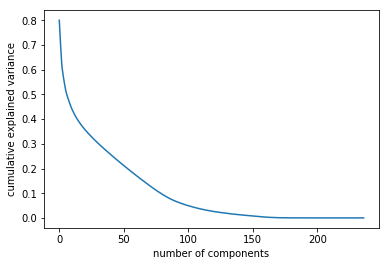

In [161]:
# Normalize data
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(train_df_randomized) 

# Reduce dimension 
pca = PCA().fit(X_train_scaled)

plt.plot(1-np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We need to keep up to <b>54 dimensions to catch 80% of inertia</b>.<br>
So we can make hypothesis but we cannot demonstrate anything with so few inertia catched on the first 3 dimensions.

In [162]:
np.cumsum(pca.explained_variance_ratio_)[0:54]

array([0.19940365, 0.29939086, 0.38372239, 0.4234901 , 0.45525359,
       0.48375926, 0.50403293, 0.51978047, 0.53460962, 0.54906586,
       0.56149408, 0.57263055, 0.58272264, 0.59210083, 0.60076384,
       0.60874361, 0.61629256, 0.62350931, 0.63033013, 0.63685563,
       0.64310419, 0.64908868, 0.65495861, 0.66060997, 0.66610012,
       0.67152398, 0.67687712, 0.68208476, 0.68728413, 0.69236322,
       0.69738728, 0.7022664 , 0.70711528, 0.71186749, 0.71653739,
       0.72120113, 0.72583256, 0.73044565, 0.73503967, 0.73960571,
       0.74413058, 0.7486325 , 0.75309985, 0.75755497, 0.76195756,
       0.76634506, 0.77070414, 0.77504955, 0.77937435, 0.78368927,
       0.78796341, 0.79222121, 0.79645906, 0.80066554])

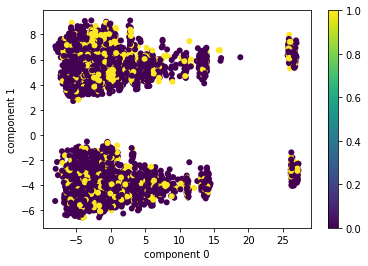

In [163]:
# Project points on firsts eigenvectors
projected = pca.fit_transform(X_train_scaled)

# And plot
def plot_projected_pts(dim1, dim2, df, target):
    plt.scatter(df[:, dim1], df[:, dim2],
            c=target.target, edgecolor='none' )
    plt.xlabel('component '+str(dim1))
    plt.ylabel('component '+str(dim2))
    plt.colorbar()

plot_projected_pts(0, 1, projected, target)    



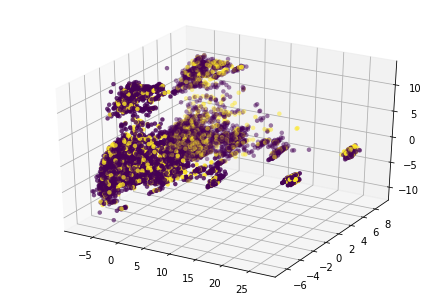

In [164]:
# Add 1 dimension to plot data with almost 50% of inertia
fig = plt.figure()
ax = Axes3D(fig)
plt.clf
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=target.target, 
           edgecolor='none')
plt.axis('tight');

We can clearly identify some spot points but each of them contains both classes : "claims" and "no claims".<br>
We cannot distinguish groups of points allowing us to associate higher claim probability given the points are embedded in a group.<br>
In other words there is no x' such that :<br>
   $P$ ( Y= $ Y_{Claims} $ | X=x'  ) is higher than $P$ ( Y= $ Y_{No Claims} $ | X=x'  )<br>
   
So it will be a bit tricky to train a model to separate these classes.   

## Looking for density with DBSCAN<p id="chapX"></p>

<br><br><font size=3.5><strong>Search outliers with DBSCAN clusters</strong></font>

----------------------


In [165]:
from sklearn.cluster import DBSCAN

In [167]:
# Identify outliers by looking at noise just before switching from only one cluster to 2
n_epss = list()
n_noise_s = list()
n_clusters_s = list()
for n_eps in np.arange(30000,50000,500): 
    db = DBSCAN(eps=n_eps, min_samples=5, n_jobs=-1).fit(train_complete_df)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    n_epss.append(n_eps)
    print("neps : "+ str(n_eps))
    n_clusters_s.append(n_clusters_)
    print("nclusters : " + str(n_clusters_))
    n_noise_s.append(n_noise_)
    print("noise : "+str(n_noise_))
    
    

neps : 30000
nclusters : 25
noise : 40
neps : 30500
nclusters : 24
noise : 40
neps : 31000
nclusters : 22
noise : 39
neps : 31500
nclusters : 21
noise : 38
neps : 32000
nclusters : 20
noise : 31
neps : 32500
nclusters : 20
noise : 31
neps : 33000
nclusters : 20
noise : 29
neps : 33500
nclusters : 20
noise : 29
neps : 34000
nclusters : 18
noise : 28
neps : 34500
nclusters : 18
noise : 28
neps : 35000
nclusters : 18
noise : 26
neps : 35500
nclusters : 18
noise : 26
neps : 36000
nclusters : 18
noise : 26
neps : 36500
nclusters : 17
noise : 26
neps : 37000
nclusters : 17
noise : 26
neps : 37500
nclusters : 17
noise : 26
neps : 38000
nclusters : 17
noise : 24
neps : 38500
nclusters : 16
noise : 23
neps : 39000
nclusters : 16
noise : 22
neps : 39500
nclusters : 15
noise : 22
neps : 40000
nclusters : 15
noise : 21
neps : 40500
nclusters : 14
noise : 21
neps : 41000
nclusters : 14
noise : 20
neps : 41500
nclusters : 14
noise : 20
neps : 42000
nclusters : 13
noise : 20
neps : 42500
nclusters : 

Text(0.5, 1.0, 'n_clusters per eps = 20000+X*500')

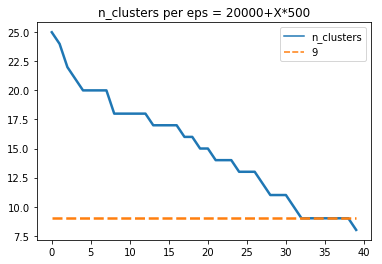

In [171]:
# Plot clusters per eps
dbscan_df = pd.DataFrame({"eps":n_epss, 
                          "n_clusters" : n_clusters_s, "n_noise" : n_noise_s})
dbscan_df["18"]=18
dbscan_df["9"]=9
sns.lineplot(data=dbscan_df.loc[:,["n_clusters","9"]], palette="tab10", linewidth=2.5).set_title("n_clusters per eps = 20000+X*500")


Text(0.5, 1.0, 'n_noise per eps = 20000+x*500')

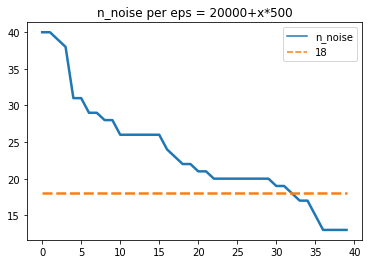

In [172]:
sns.lineplot(data=dbscan_df.loc[:,["n_noise","18"]], palette="tab10", linewidth=2.5
            ).set_title('n_noise per eps = 20000+x*500')


There is a kind of convergence for eps greater than 46 000.<br>
At this threshold we have 18 outliers and 9 clusters.<br>
As this clustering is stable for a while wr keep this shape and remove the 18 outliers.<br>

In [174]:
N_eps = 46000

In [175]:
# Get outliers indexes
db = DBSCAN(eps=N_eps, min_samples=5, n_jobs=-1).fit(train_complete_df)
labels = db.labels_
outliers_indexes = [idx for idx, e in enumerate(list(labels)) if e == -1]

In [176]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)
len(outliers_indexes)

9


18

In [177]:
set(labels) 

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8}

<br><br><font size=3.5><strong>What could we see on a 2D plot ?</strong></font>

----------------------

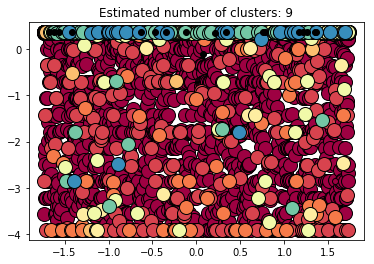

In [178]:
# Try to idenytify Outliers computing clusters with DBSCAN
# We won't go further than 10^-11 because of computational error and so no real means over this threshold.
db = DBSCAN(eps=N_eps, min_samples=5, n_jobs=-1).fit(train_complete_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_train_scaled[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_train_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

These 9 clusters are not obvious on this type of graph. 

<br><br><font size=3.5><strong>Look for shapes with K-Means++</strong></font>

----------------------
We will look at the projecton on the 3 firsts dimensions but it will demonstrate nothing we catch really few inertia with these dimensions.<br>
We will only make hypothesis and check their relevancy trying to exploit them in our model farther.

In [181]:
from sklearn.cluster import KMeans

Text(0.5, 0.92, 'Claims clusters')

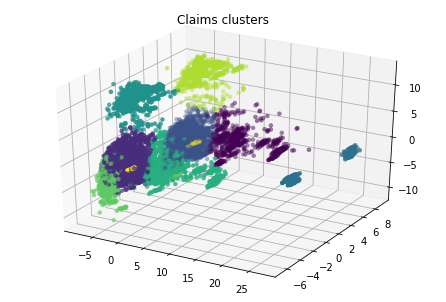

In [182]:
# Number of clusters
N_Clusters = 9
y_clusters = KMeans(n_clusters=N_Clusters, init='k-means++', random_state=41).fit_predict(projected)

fig = plt.figure()
ax = Axes3D(fig)
plt.clf
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=y_clusters, 
           edgecolor='none')

plt.axis('tight');
plt.title("Claims clusters")

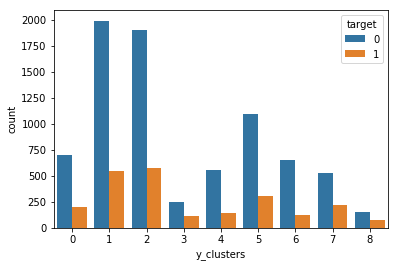

In [183]:
# Analyze Kmeans++ clusters 
train_complete_df["CODGEO"] = CODGEO.copy()
X_kmeans_df = pd.concat((pd.DataFrame(train_complete_df),pd.DataFrame(y_clusters), target ), axis = 1)
X_kmeans_df.columns   =    list(train_complete_df.columns)+["y_clusters"]+["target"]                     
sns.countplot(X_kmeans_df["y_clusters"], hue=X_kmeans_df["target"])

It seems that there is more claims for the clusters 3, 7 and 8 and less for other clusters.<br>
We hope so that these new features will help the model to identify the claim risk.

In [186]:
for c_cluster in range(0,N_Clusters):
    print(c_cluster)
    t_kmean = X_kmeans_df[X_kmeans_df["y_clusters"]==c_cluster]
    print(t_kmean["CODGEO"].str[:2].value_counts()[:9])


0
33    96
06    92
63    77
66    49
42    46
38    40
83    40
59    39
13    39
Name: CODGEO, dtype: int64
1
06    275
64    180
38    149
13    142
83    140
74    125
34     94
42     88
2B     85
Name: CODGEO, dtype: int64
2
06    247
83    211
74    150
64    134
13    122
38    115
62     92
2A     81
34     70
Name: CODGEO, dtype: int64
3
06    238
31    122
Name: CODGEO, dtype: int64
4
92    211
94    145
93    102
91     80
77     54
95     43
78     38
54      6
06      5
Name: CODGEO, dtype: int64
5
06    189
21    109
33     96
13     88
34     75
83     70
42     67
86     63
63     62
Name: CODGEO, dtype: int64
6
30    62
62    53
34    47
74    46
05    40
83    39
88    30
14    29
73    24
Name: CODGEO, dtype: int64
7
92    206
94    135
78    113
77     73
93     71
95     60
91     55
21      5
38      4
Name: CODGEO, dtype: int64
8
06    226
Name: CODGEO, dtype: int64


Clusters 7 is linked to the "Ile de France" when cluster 8 is a subpart of "Alpes - Maritimes". <br>
We see on the map displaying claims ratio that "Indre" has high claims ratio but do not appear in our clusters.<br>
We will add the claims ratio as a new feature to score department with past claims observed.

In [202]:
# Create department claim score
Dept_df = pd.concat((train_complete_df,pd.DataFrame({"Dpt_Code":Insee.str[:2], "target":target.target})),axis=1)
Dept_Score = Dept_df.groupby("Dpt_Code")["target"].mean()
train_complete_df["Dpt_Score"] = Dept_df["Dpt_Code"].apply(lambda x : Dept_Score.get(x))
train_complete_df["Dpt_Score"].head()

0   0.077
1   0.237
2   0.352
3   0.263
4   0.248
Name: Dpt_Score, dtype: float64


<br><br><font size=3.5><strong>Create new features based on [KMeans++| DBSCAN] clusters </strong></font>

----------------------


In [660]:
# Function to add encoded new variables identifying a row to a cluster established with DBSCAN or KMeans++
def encode_clusters(train_complete_df, model_clustering, N_eps=40000):
    
    # Build clusters depnding on a clustering modelization
    if model_clustering == "KMeans":
        ### Create a new features with the kmeans++ cluster 
        y_clusters = KMeans(n_clusters=N_Clusters, init='k-means++', random_state=41).fit_predict(train_complete_df)
    elif model_clustering == "DBSCAN":
        db = DBSCAN(eps=N_eps, min_samples=5, n_jobs=-1).fit(train_complete_df)
        y_clusters = db.labels_
        
    train_complete_df = pd.concat((train_complete_df.reset_index(drop=True), pd.DataFrame({"y_clusters":y_clusters}) ), axis = 1)
    #train_complete_df.rename({0:"y_clusters"}, axis="columns", inplace=True)
    
    # Transform data to strings
    col = "y_clusters"
    train_complete_df[col] = train_complete_df[col].apply(lambda x: str(x).rstrip().replace(" ",""))
    train_complete_df[col] = train_complete_df[col].apply(lambda x: str(x))
    
    # Check all values to transform them to new binary column
    good_cols = [col+'_'+i for i in train_complete_df[col].unique()]
    train_complete_df = pd.concat((train_complete_df, pd.get_dummies(train_complete_df[col], prefix = col)[good_cols]), axis = 1)
    del train_complete_df[col]
    
    return train_complete_df


#Add Cluster number as a new feature
del train_complete_df["CODGEO"]
train_complete_df = encode_clusters(train_complete_df, "DBSCAN", N_eps=40000)
train_complete_df.columns

Index(['index', 'EXPO', 'ft_2_categ_2014', 'ft_2_categ_2013',
       'ft_2_categ_2015', 'ft_2_categ_2016', 'ft_2_categ_2012', 'ft_4_categ_0',
       'ft_4_categ_1', 'ft_5_categ_V',
       ...
       'y_clusters_1', 'y_clusters_2', 'y_clusters_3', 'y_clusters_4',
       'y_clusters_5', 'y_clusters_6', 'y_clusters_7', 'y_clusters_8',
       'y_clusters_9', 'y_clusters_-1'],
      dtype='object', length=250)

## Data correlation<p id="chapXI"></p>

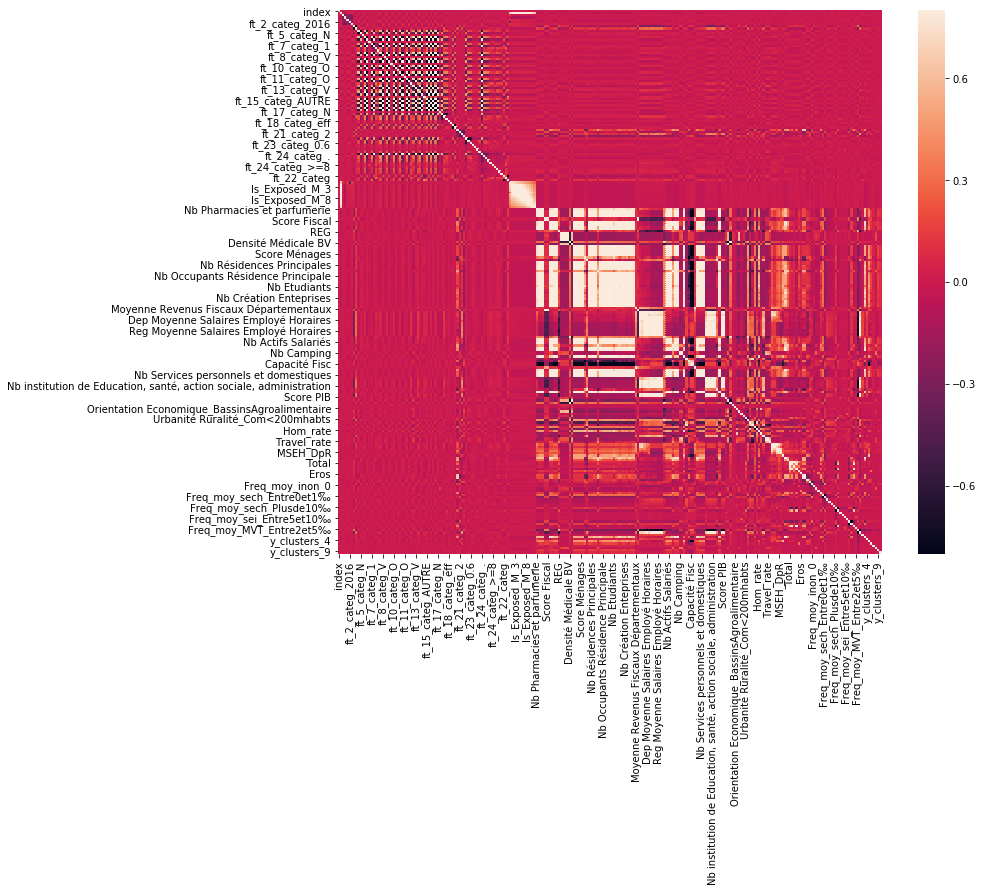

In [663]:
#Build a heatmap to cheack numeric feature correlations 
ax = plt.subplots(figsize=(13, 10))
sns.heatmap(train_complete_df.select_dtypes(include=[np.number]).corr(), vmin=-0.8, vmax=0.8, square=True)

We see in this last heatmap that we have very correlated features for features coming from the same data source.
For example, features coming from the "commune" data are correlated when they deal with "principal residence" number, population, student number in the city and so on.<br>
In the same way we have correlation between different data regarding earnings.<br>
There are also correlation coming from their own definition for categorical variables.<br>
By building model we will have to deal with this point, for example by ordering features through their importance in a model with default parameters and then to remove correlated features one by one.